## Author: Denys Herasymuk

**Variant**: the remainder of the division = 3

## Contents of This Notebook

Click on the section and go to this cell immediately.

* [Section 1. Explore Data](#section_1)
* [Section 2. Identifying Stationarity](#section_2)
* [Section 3. Nonstationary-to-Stationary Transformations](#section_3)
* [Section 4. Correlation analysis](#section_4)
* [Section 5. Feature generation and validation of DL models](#section_5)
* [Section 6. Fbprophet and Nbeats models](#section_6)
* [Section 7. Predict on 12 months out of dataframe](#section_7)


When you use Run All button with this notebook, you should wait approx. 10-15 mins to get output of all cells.

**How to run this notebook**

* Create a new conda env with python 3.7
* Run `jupyter notebook` in your new env via terminal (without installing any packages now)
* Based on (this link)[https://stackoverflow.com/questions/61353951/no-module-named-fbprophet]. Run these two cells in your jupyter:
```
!conda install -c conda-forge fbprophet -y
!pip install --upgrade plotly
```

* In terminal run  -- `pip install -r requirements.txt`
* In any case, a useful command -- `conda create --clone py35 --name py35-2` from here -- https://docs.conda.io/projects/conda/en/4.6.0/_downloads/52a95608c49671267e40c689e0bc00ca/conda-cheatsheet.pdf

* How to install pytorch -- https://pytorch.org/get-started/locally/
* In such a way I installed it on Ubuntu
`pip3 install torch==1.10.0+cpu torchvision==0.11.1+cpu torchaudio==0.10.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html`

* Nbeats installing -- `pip3 install nbeats-pytorch`

## General Configuration

In [12]:
import os
import sys
import math
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import statsmodels as ss
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
# from fbprophet import Prophet
# from prophet.diagnostics import performance_metrics, cross_validation
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector

from pprint import pprint
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller

In [13]:
%matplotlib inline

alt.data_transformers.disable_max_rows()
alt.renderers.enable('html')

plt.style.use('mpl20')
# plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

## Python & Library Versions

In [14]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("statsmodels", ss.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__),
             ("keras", keras.__version__),
             ("xgboost", xgboost.__version__),
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.4
statsmodels 0.12.2
seaborn     0.11.2
sklearn     1.0.2
keras       2.3.1
xgboost     1.5.0


<a id='section_1'></a>

## Section 1. Explore Data

In [15]:
original_df = pd.read_csv(os.path.join("..", "data", "dataset1_SolarPrediction.csv"))

In [16]:
original_df.head(10)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
5,1475227824,9/29/2016 12:00:00 AM,23:30:24,1.21,48,30.46,64,120.20,5.62,06:13:00,18:13:00
6,1475227519,9/29/2016 12:00:00 AM,23:25:19,1.20,49,30.46,72,112.45,6.75,06:13:00,18:13:00
7,1475227222,9/29/2016 12:00:00 AM,23:20:22,1.24,49,30.46,71,122.97,5.62,06:13:00,18:13:00
8,1475226922,9/29/2016 12:00:00 AM,23:15:22,1.23,49,30.46,80,101.18,4.50,06:13:00,18:13:00
9,1475226622,9/29/2016 12:00:00 AM,23:10:22,1.21,49,30.46,85,141.87,4.50,06:13:00,18:13:00


In [17]:
original_df.shape

(32686, 11)

In [18]:
original_df.columns

Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')

In [19]:
original_df.dtypes

UNIXTime                    int64
Data                       object
Time                       object
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
TimeSunRise                object
TimeSunSet                 object
dtype: object

In [20]:
original_df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [21]:
original_df.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [22]:
# area_df.Area_New = area_df.Area_New.interpolate()

## Data Preprocessing

### UNIX time to datetime transformation

In [23]:
datetime_series = original_df.copy()
datetime_series.index = pd.to_datetime(datetime_series['UNIXTime'], unit='s') - timedelta(hours=10)  # also include timezone shift

datetime_series['DateTime'] = datetime_series.index
datetime_series.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,DateTime
UNIXTime,,,,,,,,,,,,
2016-09-29 23:55:26,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-29 23:55:26
2016-09-29 23:50:23,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-29 23:50:23
2016-09-29 23:45:26,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-29 23:45:26
2016-09-29 23:40:21,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-29 23:40:21
2016-09-29 23:35:24,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-29 23:35:24


In [24]:
radiation_df = datetime_series.drop(['UNIXTime', 'Data', 'Time', 'Temperature','TimeSunRise', 'TimeSunSet',
                                        'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed' ], axis=1)

In [25]:
radiation_df['Year'] = radiation_df.DateTime.dt.year
radiation_df['Month'] = radiation_df.DateTime.dt.month
radiation_df['Day'] = radiation_df.DateTime.dt.day
radiation_df['Hour'] = radiation_df.DateTime.dt.hour
radiation_df['Day_of_week'] = radiation_df.DateTime.dt.dayofweek

In [26]:
def weekend_transform(row):
    return int(row.dayofweek == 5 or row.dayofweek == 6)

radiation_df['Weekend'] = radiation_df['DateTime'].apply(weekend_transform)
radiation_df['Hourly_DateTime'] = pd.to_datetime(dict(year=radiation_df.Year, month=radiation_df.Month, day=radiation_df.Day, hour=radiation_df.Hour))

In [27]:
radiation_df.head()

,Radiation,DateTime,Year,Month,Day,Hour,Day_of_week,Weekend,Hourly_DateTime
UNIXTime,,,,,,,,,
2016-09-29 23:55:26,1.21,2016-09-29 23:55:26,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:50:23,1.21,2016-09-29 23:50:23,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:45:26,1.23,2016-09-29 23:45:26,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:40:21,1.21,2016-09-29 23:40:21,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:35:24,1.17,2016-09-29 23:35:24,2016,9,29,23,3,0,2016-09-29 23:00:00


In [28]:
print(f'Data time range: from {radiation_df.DateTime.unique().min()} to {radiation_df.DateTime.unique().max()}')

Data time range: from 2016-09-01T00:00:08.000000000 to 2016-12-31T23:55:01.000000000


In [37]:
hourly_radiation_df = radiation_df.groupby(['Hourly_DateTime']).mean()
hourly_radiation_df.head(20)

,Radiation,Year,Month,Day,Hour,Day_of_week,Weekend
Hourly_DateTime,,,,,,,
2016-09-01 00:00:00,2.288750,2016.0,9.0,1.0,0.0,3.0,0.0
2016-09-01 01:00:00,2.943333,2016.0,9.0,1.0,1.0,3.0,0.0
2016-09-01 02:00:00,2.733333,2016.0,9.0,1.0,2.0,3.0,0.0
2016-09-01 03:00:00,2.344545,2016.0,9.0,1.0,3.0,3.0,0.0
2016-09-01 04:00:00,2.607500,2016.0,9.0,1.0,4.0,3.0,0.0
2016-09-01 05:00:00,1.769000,2016.0,9.0,1.0,5.0,3.0,0.0
2016-09-01 06:00:00,23.375000,2016.0,9.0,1.0,6.0,3.0,0.0
2016-09-01 07:00:00,120.567778,2016.0,9.0,1.0,7.0,3.0,0.0
2016-09-01 08:00:00,464.377500,2016.0,9.0,1.0,8.0,3.0,0.0


In [ ]:
hourly_radiation_df['Log_Radiation'] = np.log(hourly_radiation_df.Radiation)

<a id='section_2'></a>
## Section 2. Identifying Stationarity

In [47]:
def run_sequence_plot(df, y_column, title, from_datetime=None, to_datetime=None):
    if not from_datetime:
        from_datetime = df.index.min()
    if not to_datetime:
        to_datetime = df.index.max()

    plt.plot(df[from_datetime: to_datetime].index, df[y_column][from_datetime: to_datetime].values, color='blue', label="Radiation")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

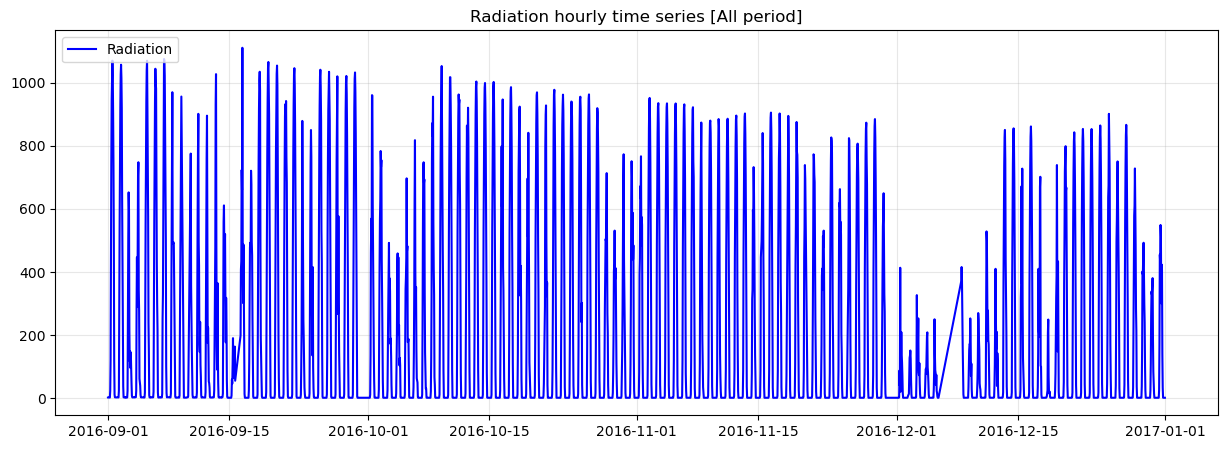

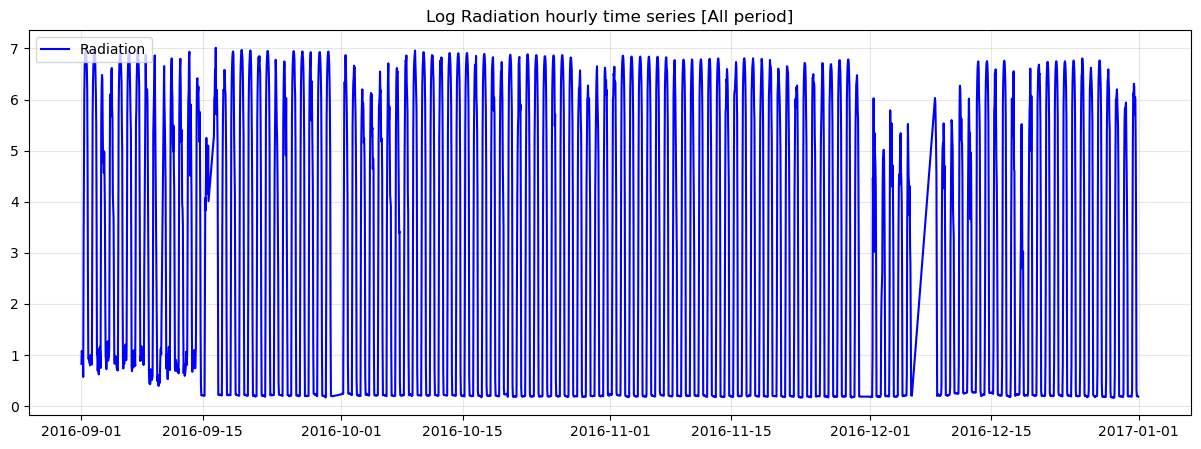

In [49]:
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [All period]')
run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [All period]')

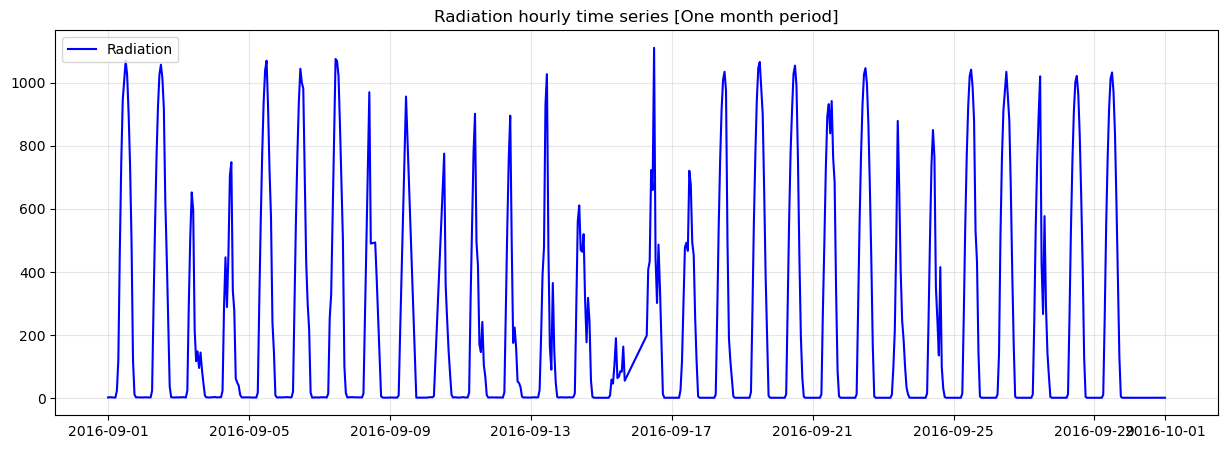

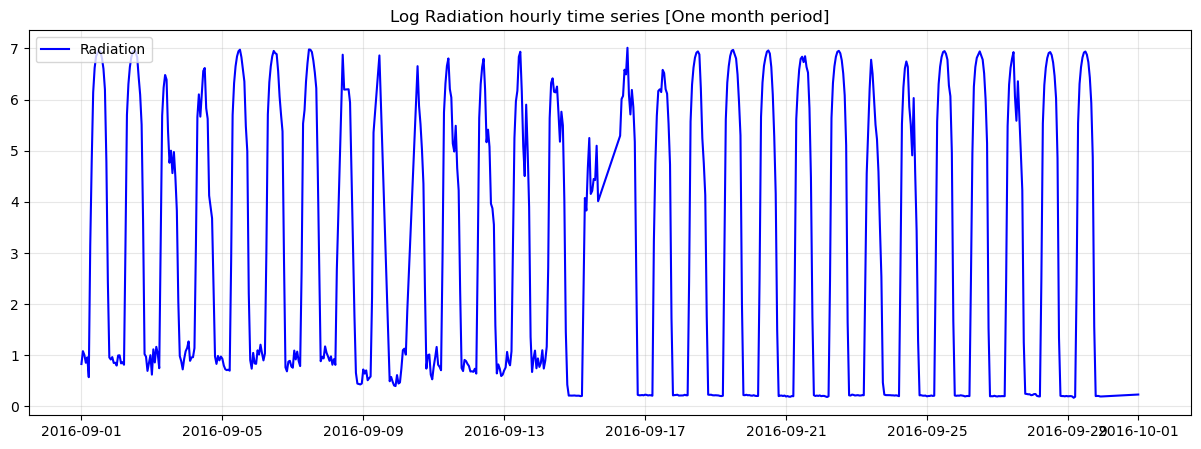

In [50]:
from_datetime = datetime(year=2016, month=9, day=1, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One month period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=30))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One month period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=30))

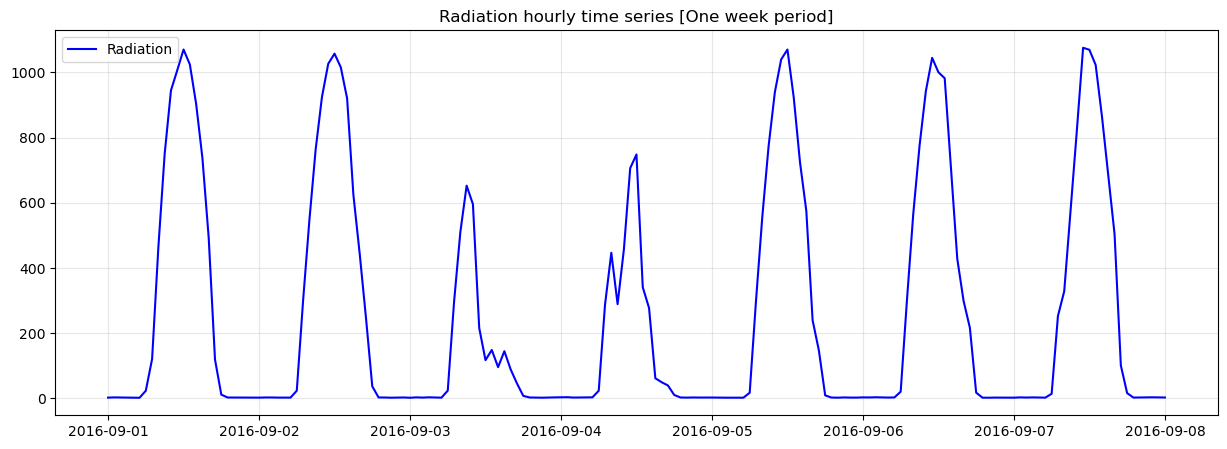

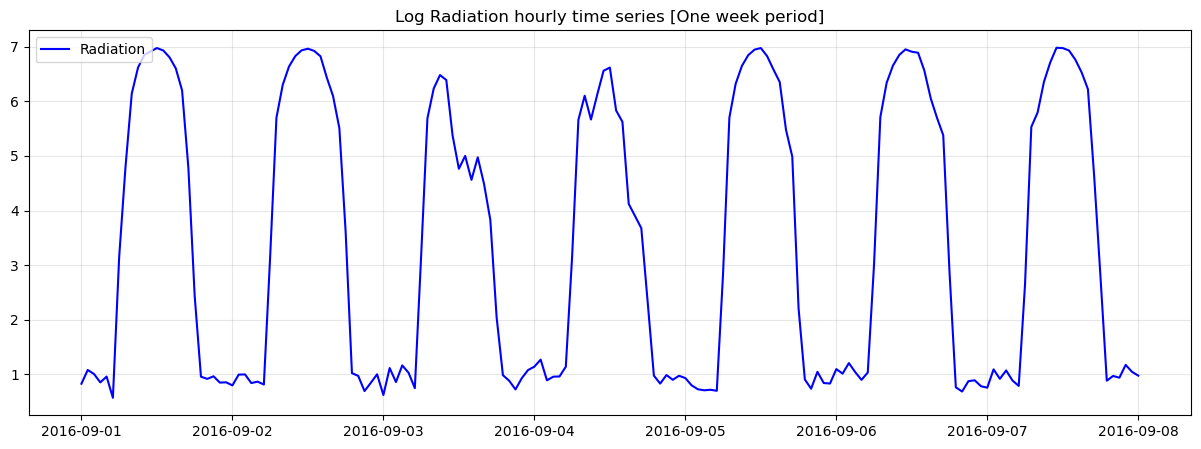

In [51]:
from_datetime = datetime(year=2016, month=9, day=1, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One week period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=7))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One week period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=7))

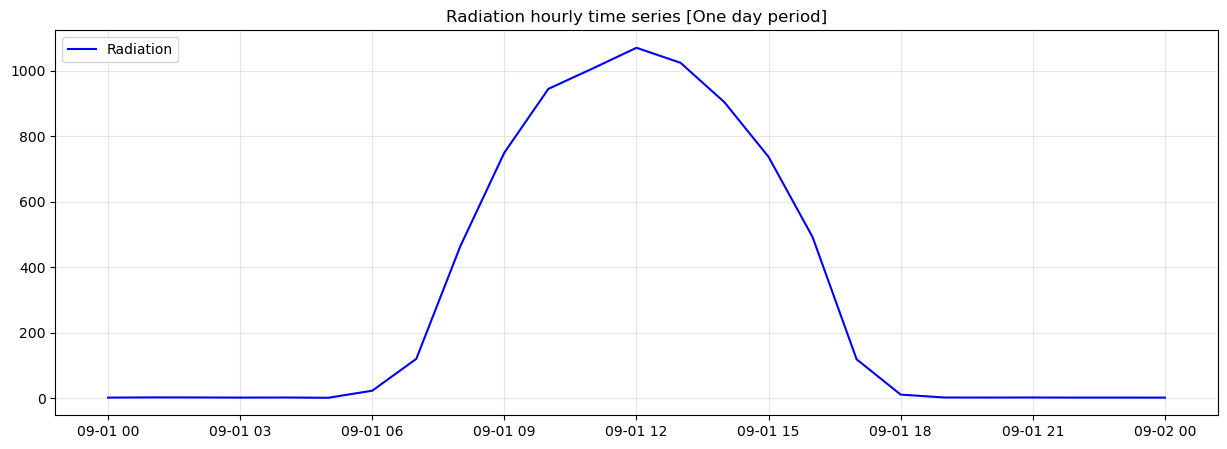

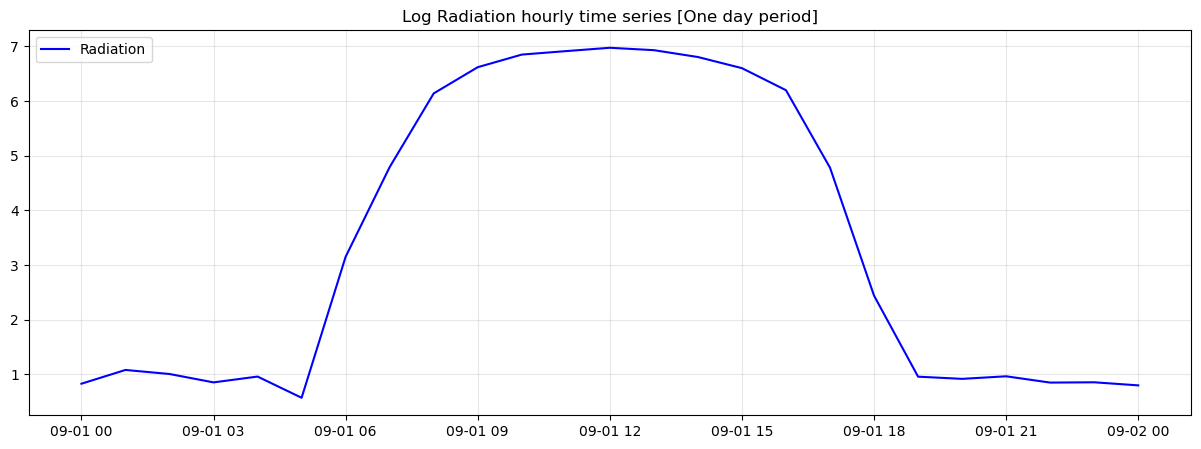

In [53]:
from_datetime = datetime(year=2016, month=9, day=1, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One day period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=1))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One day period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=1))

### Summary Statistics & Plots (additive hypothesis)

First way to check for constant mean and variance is to chop up the data into separate chunks, calculate statistics for each chunk, and compare

In [54]:
hourly_radiation_df.head()

,Radiation,Year,Month,Day,Hour,Day_of_week,Weekend,Log_Radiation
Hourly_DateTime,,,,,,,,
2016-09-01 00:00:00,2.288750,2016.0,9.0,1.0,0.0,3.0,0.0,0.828006
2016-09-01 01:00:00,2.943333,2016.0,9.0,1.0,1.0,3.0,0.0,1.079543
2016-09-01 02:00:00,2.733333,2016.0,9.0,1.0,2.0,3.0,0.0,1.005522
2016-09-01 03:00:00,2.344545,2016.0,9.0,1.0,3.0,3.0,0.0,0.852092
2016-09-01 04:00:00,2.607500,2016.0,9.0,1.0,4.0,3.0,0.0,0.958392


In [55]:
# Compare means and variances
radiation_statistics_df = pd.DataFrame()
radiation_statistics_df['Radiation_Mean'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Radiation'].mean()
radiation_statistics_df['Radiation_Variance'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Radiation'].var()

In [56]:
radiation_statistics_df[['Radiation_Mean', 'Radiation_Variance']]

Radiation_Mean  Radiation_Variance
Year   Month Day                                     
2016.0 9.0   1.0       320.590444       175747.025822
             2.0       331.381442       168959.364380
             3.0       123.712194        38405.958544
             4.0       156.929714        54028.312871
             5.0       305.647065       158560.760349
...                           ...                 ...
       12.0  27.0      239.910556       109522.510072
             28.0      174.910278        62409.321688
             29.0      125.138848        31309.002043
             30.0       89.250305        18455.692430
             31.0      144.288542        40916.125465

[118 rows x 2 columns]

#### Histograms

<AxesSubplot:>

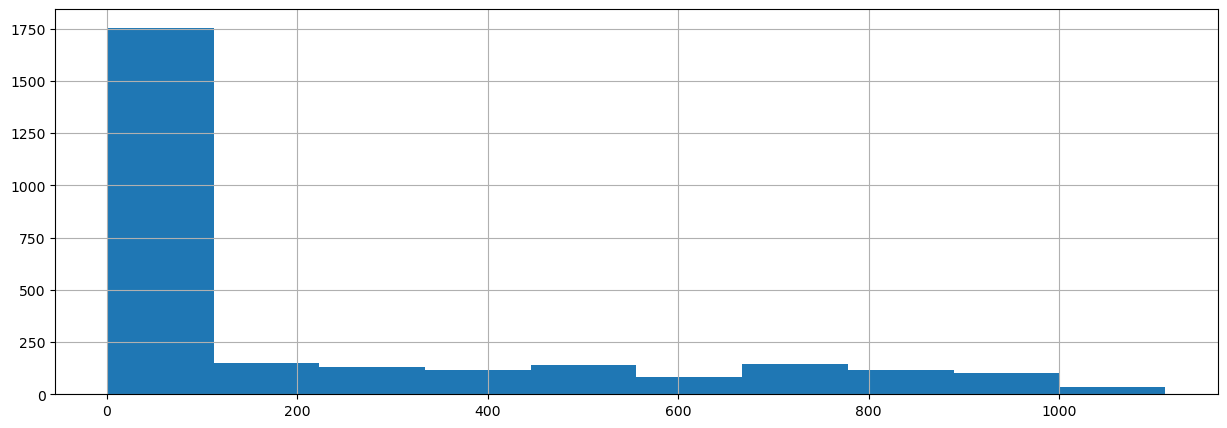

In [66]:
hourly_radiation_df.Radiation.hist()

<AxesSubplot:>

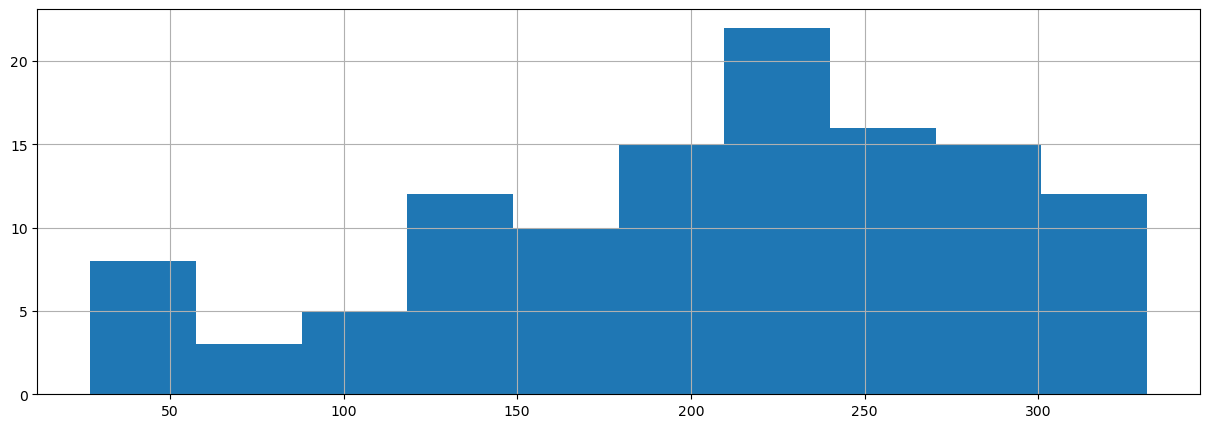

In [62]:
radiation_statistics_df['Radiation_Mean'].hist()

<AxesSubplot:>

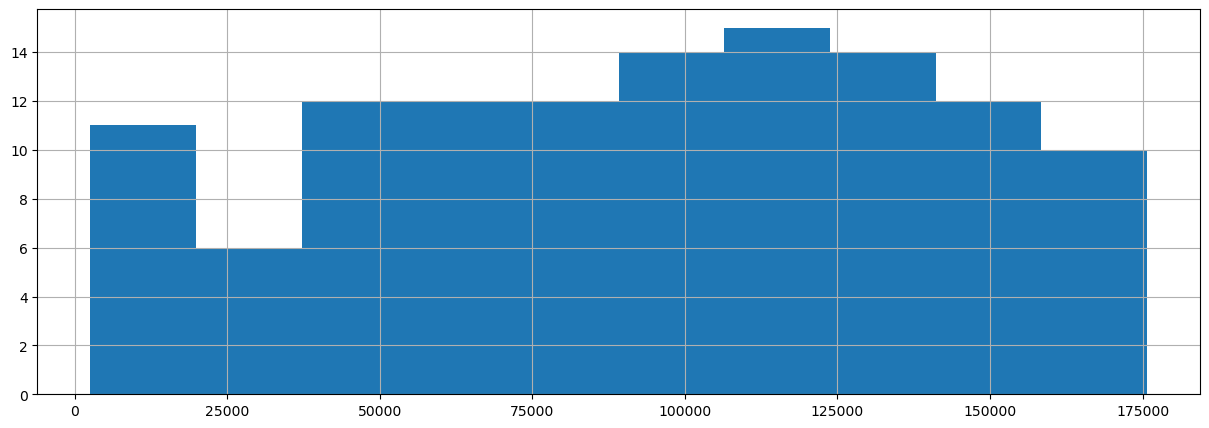

In [61]:
radiation_statistics_df['Radiation_Variance'].hist()

#### Augmented Dickey-Fuller Test

What you need to know:
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null.
> The value 0.05 is common but depends upons numerous factors.

In [65]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_radiation_df['Radiation'], regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -5.255832418677891
p-value: 6.755180356560368e-06


#### Explanation (additive hypothesis)

Based on histograms and augmented Dickey-Fuller test with **p-value < 0.05** we can reject null hypothesis that the time series is non-stationary.
Therefore, our data is **stationary**.

### Summary Statistics & Plots (multiplicative hypothesis)

In [29]:
# Compare means and variances
radiation_statistics_df['Log_Radiation_Mean'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Log_Radiation'].mean()
radiation_statistics_df['Log_Radiation_Variance'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Log_Radiation'].var()

Chunk | Mean    | Variance
--------------------------
    1 | 4.83066 | 0.02477
    2 | 5.04831 | 0.0579251
    3 | 4.99099 | 0.0204384
    4 | 5.01947 | 0.00666502
    5 | 4.90986 | 0.0191027
    6 | 5.03494 | 0.0319071
    7 | 5.04041 | 0.0284908
    8 | 5.088 | 0.0277435
    9 | 5.16424 | 0.0384146
   10 | 5.16247 | 0.0295748
   11 | 5.34207 | 0.00887281
   12 | 5.32466 | 0.0147138
   13 | 5.26425 | 0.0132272
   14 | 5.35738 | 0.0373704
   15 | 5.3672 | 0.0334408
   16 | 5.31376 | 0.026709
   17 | 5.25129 | 0.0380321
   18 | 5.30247 | 0.0665376
   19 | 5.15109 | 0.0196884
   20 | 5.27508 | 0.0356904


#### Histograms

<AxesSubplot:>

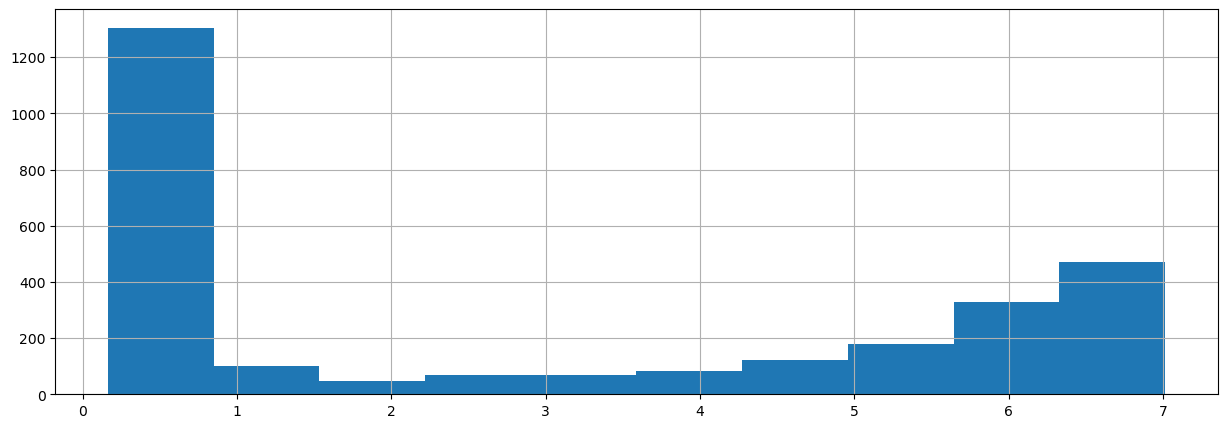

In [69]:
hourly_radiation_df.Log_Radiation.hist()

<AxesSubplot:>

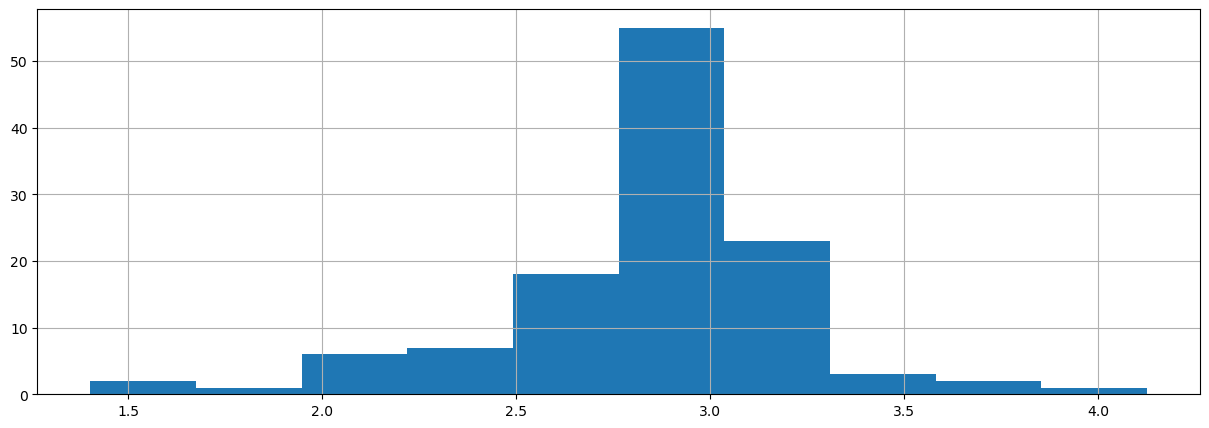

In [67]:
radiation_statistics_df['Log_Radiation_Mean'].hist()

<AxesSubplot:>

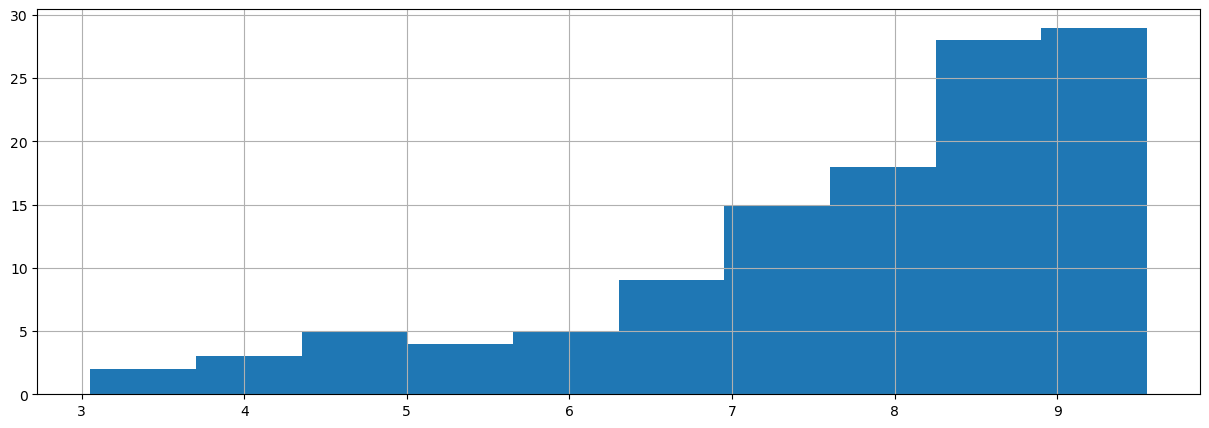

In [68]:
radiation_statistics_df['Log_Radiation_Variance'].hist()

#### Augmented Dickey-Fuller Test

In [70]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_radiation_df.Log_Radiation, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -6.614177602643125
p-value: 6.26749743784124e-09


#### Explanation (multiplicative hypothesis)

Based on histograms and augmented Dickey-Fuller test with **p-value < 0.05** we can reject null hypothesis that the time series is non-stationary.
Therefore, our data is **stationary**.

<a id='section_3'></a>
## Section 3. Nonstationary-to-Stationary Transformations

Let's create a few stationary time series from our non-stationary ones, to test, which of them will give us the best score.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


def get_polynomial_trend_prediction(trend):
    X = trend.index[:, np.newaxis]
    y = trend.values[:, np.newaxis]

    poly_reg = PolynomialFeatures(degree=2)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    polynomial_trend_prediction = pol_reg.predict(poly_reg.fit_transform(X))

    # Visualizing the Polymonial Regression results
    plt.scatter(X, y, color='red')
    plt.plot(X, polynomial_trend_prediction, color='blue')
    plt.ylabel('Production')
    plt.show()

    return polynomial_trend_prediction.flatten()

### Approach #1: Remove Trend & Seasonality with Statsmodels

#### Additive hypothesis

In [33]:
OtherPEN_production

,index,Year,Month,Production,Date,Log_production
0,711,1998,1,89.690,1998-01-01,4.496359
1,712,1998,2,112.724,1998-02-01,4.724942
2,713,1998,3,113.573,1998-03-01,4.732446
3,714,1998,4,113.454,1998-04-01,4.731397
4,715,1998,5,119.671,1998-05-01,4.784746
...,...,...,...,...,...,...
232,943,2017,5,211.911,2017-05-01,5.356166
233,944,2017,6,180.407,2017-06-01,5.195215
234,945,2017,7,232.763,2017-07-01,5.450021
235,946,2017,8,238.452,2017-08-01,5.474168


In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

SHIFT = 6
PERIOD = 12

ss_decomposition = seasonal_decompose(x=OtherPEN_production['Production'], model='additive', period=PERIOD)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

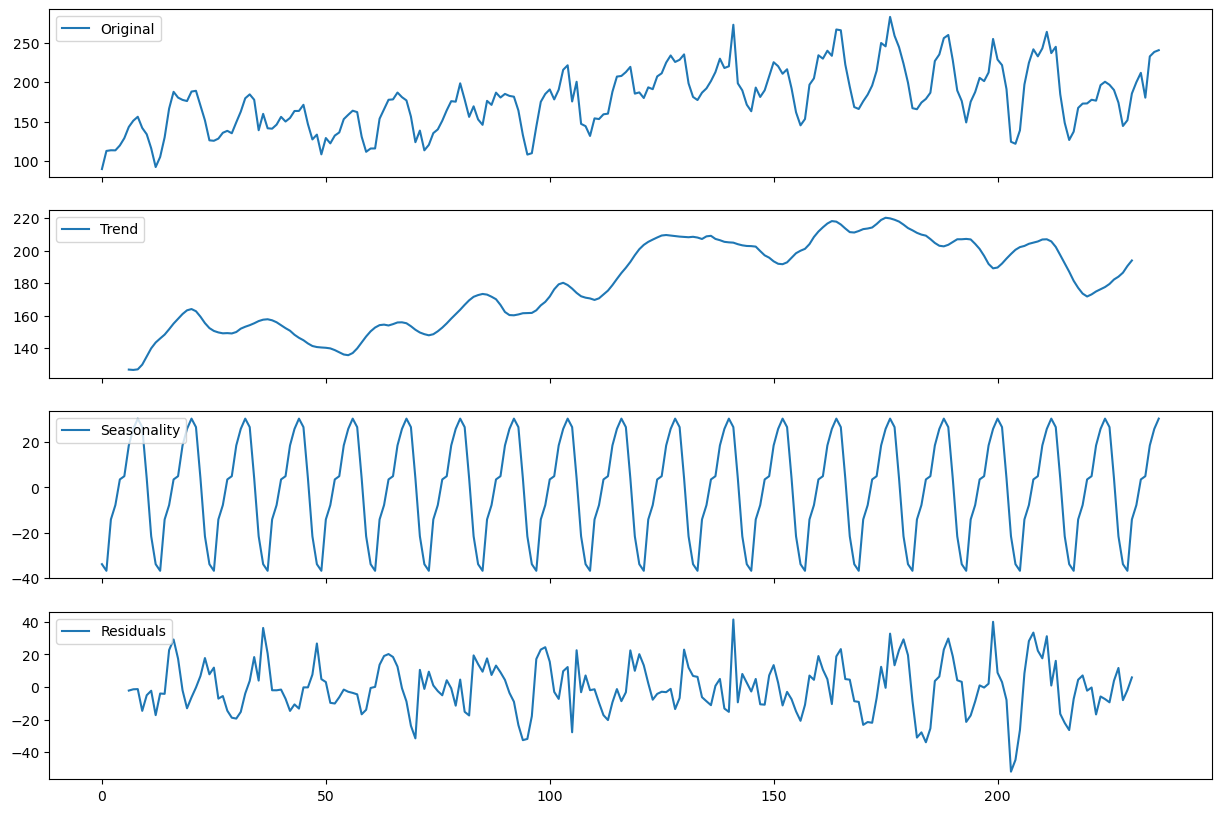

In [35]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(OtherPEN_production['Production'], label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left')

In [36]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual[SHIFT:-SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

additive_decomposed_production = estimated_residual[SHIFT:-SHIFT].reset_index(drop=True)
additive_decomposed_trend = estimated_trend[SHIFT: -SHIFT]
additive_decomposed_seasonal = estimated_seasonal

ADF:  -7.7381245644445285
p-value:  1.0798926237633178e-11


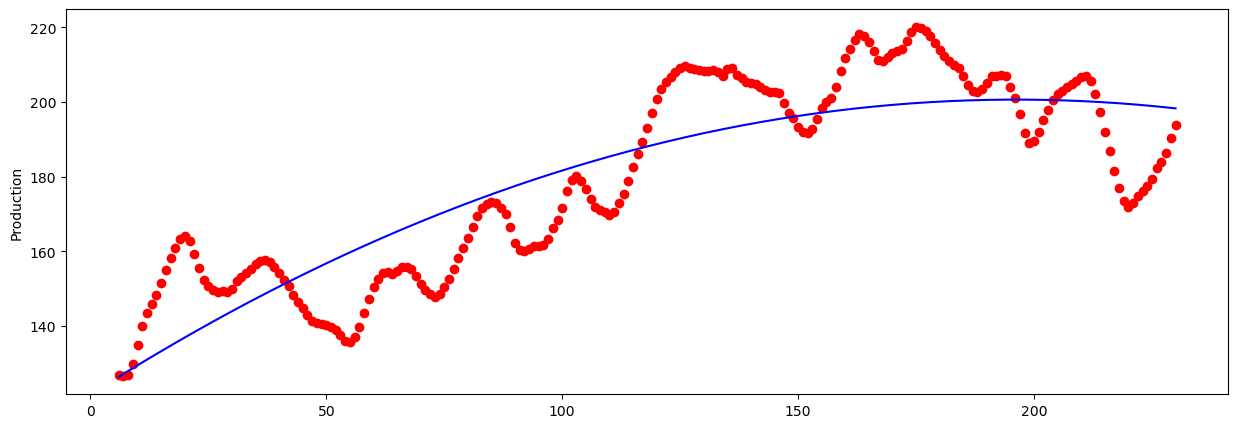

In [37]:
# predict our trent with polynomial of second degree to use it for forecast on test set
additive_decomposed_trend_prediction = get_polynomial_trend_prediction(additive_decomposed_trend)

#### Multiplicative hypothesis

In [38]:
# used model='multiplicative' to split on trend, seasonal and residuals
ss_decomposition = seasonal_decompose(x=OtherPEN_production['Production'], model='multiplicative', period=PERIOD)
estimated_trend2 = ss_decomposition.trend
estimated_seasonal2 = ss_decomposition.seasonal
estimated_residual2 = ss_decomposition.resid

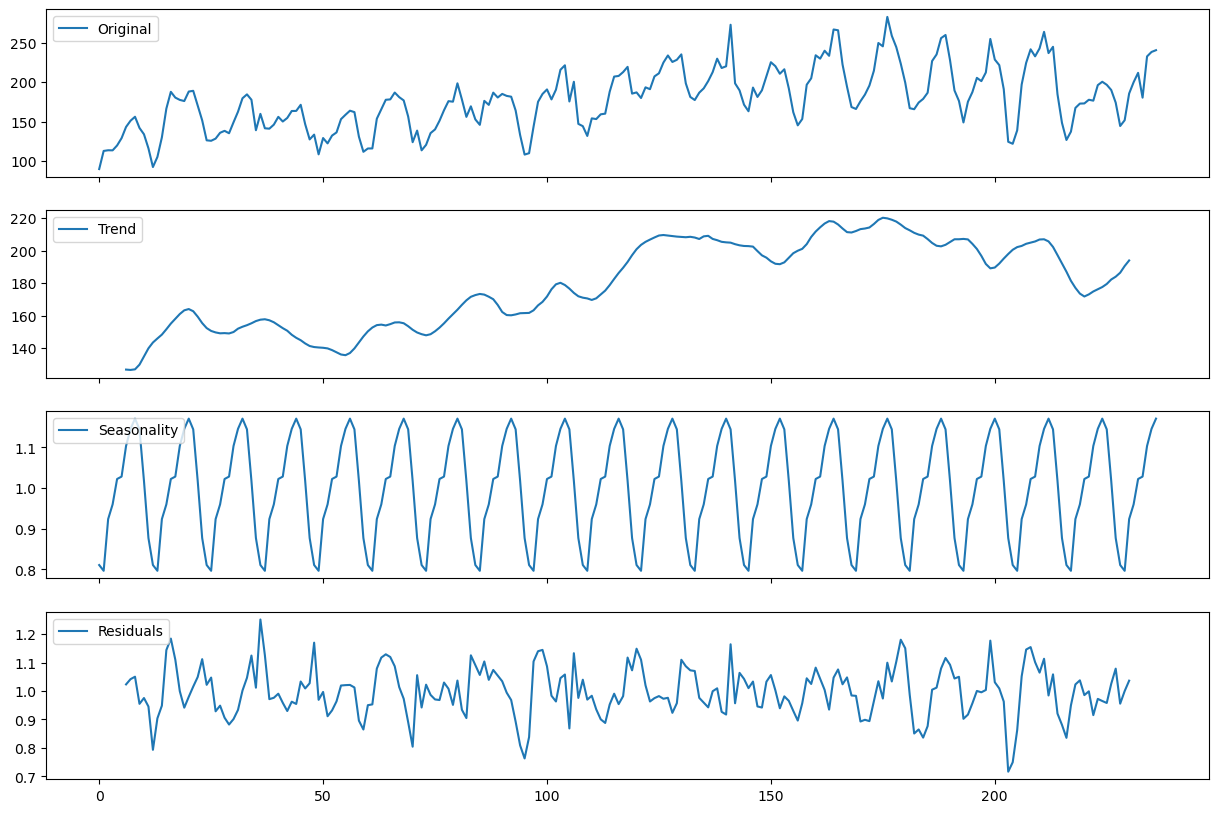

In [39]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(OtherPEN_production['Production'], label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend2, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal2, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual2, label='Residuals')
axes[3].legend(loc='upper left')

In [40]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual2[SHIFT:-SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

multiplicative_decomposed_production = estimated_residual2[SHIFT:-SHIFT].reset_index(drop=True)
multiplicative_decomposed_trend = estimated_trend2[SHIFT: -SHIFT]
multiplicative_decomposed_seasonal = estimated_seasonal2

ADF:  -7.389121805283543
p-value:  8.088081088593414e-11


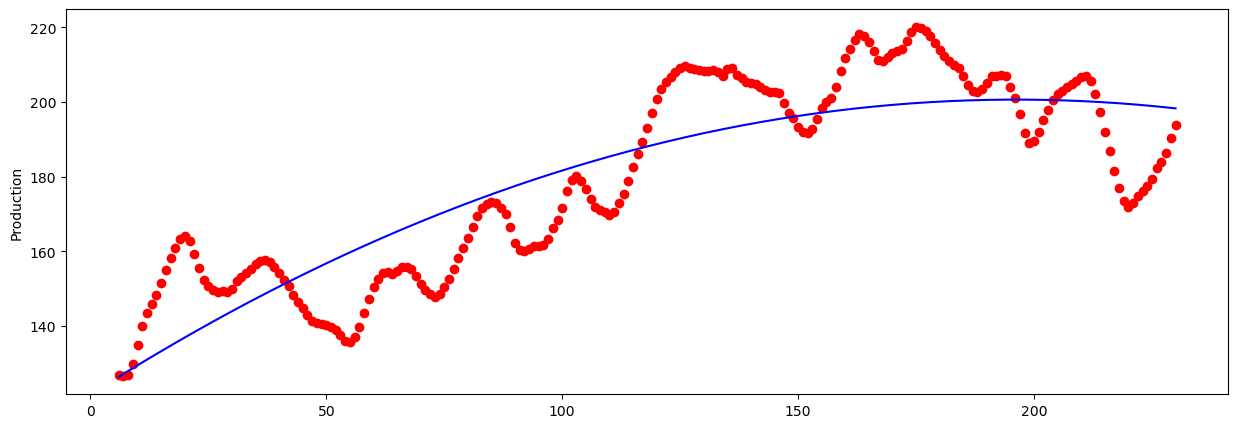

In [41]:
# predict our trent with polynomial of second degree to use it for forecast on test set
multiplicative_decomposed_trend_prediction = get_polynomial_trend_prediction(multiplicative_decomposed_trend)

#### Note!

Now **both additive_decomposed_production and multiplicative_decomposed_production are stationary**, what we can observe from plots of residuals and augmented Dickey-Fuller tests (both p-values < 0.05).

### Approach #2: Log Transformation

As our time series of multiplicative hypothesis was non-stationary, so this approach did not help to make our initial OtherPEN_production['Production'] stationary.

### Approach #3: Removing Autocorrelation with Differencing

Let's subtract $O_{t-1}$ from $O_{t}$ where $O_{t}$ is the observed data at time *t* and $O_{t-1}$ is the observed data at *t-1*.

#### Additive hypothesis

Here ew use differencing approach with lag = 1 (to reduce trend) and lag = 12 (to reduce sessonality).

##### First difference

In [1212]:
additive_diff_production_1 = OtherPEN_production['Production'].diff(PERIOD).diff(1)

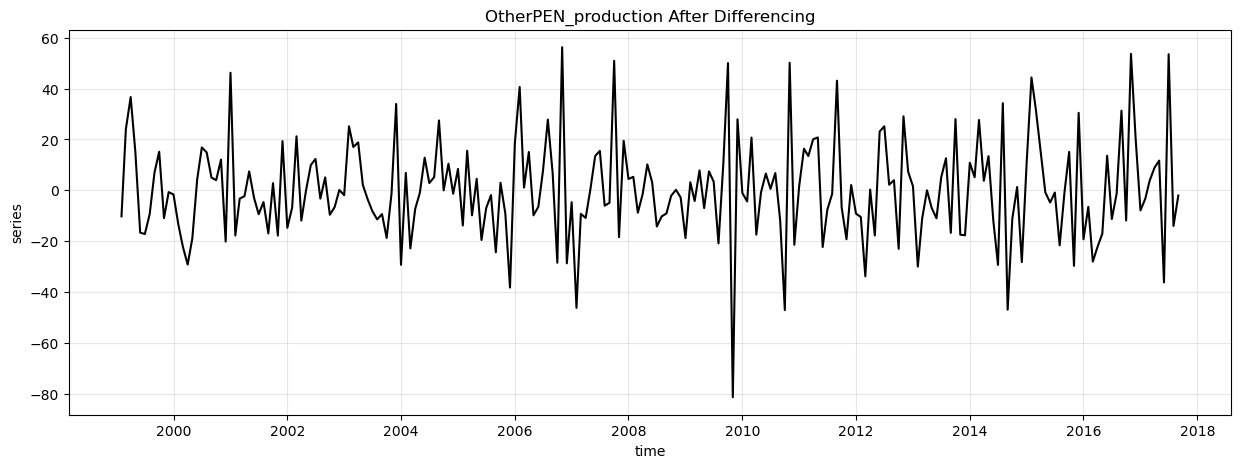

In [1213]:
run_sequence_plot(OtherPEN_production['Date'], additive_diff_production_1,
                  title="OtherPEN_production After Differencing")

In [1214]:
additive_diff_production_1 = additive_diff_production_1[1 + PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -8.132801816313718
p-value:  1.0788892336524247e-12


##### Second difference

In [1215]:
additive_diff_production_12 = OtherPEN_production['Production'].diff(PERIOD)

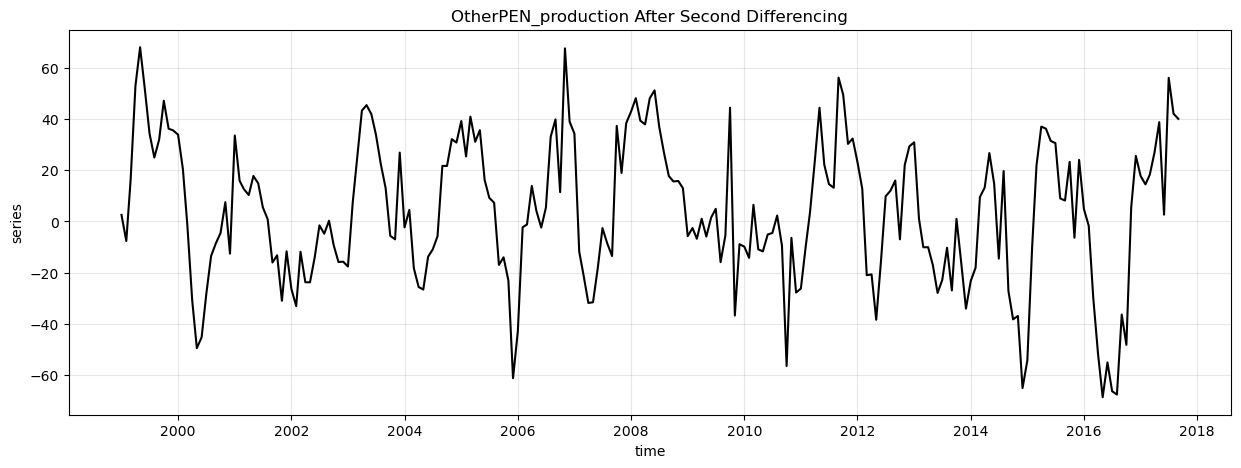

In [1216]:
run_sequence_plot(OtherPEN_production['Date'], additive_diff_production_12,
                  title="OtherPEN_production After Second Differencing")

In [1217]:
additive_diff_production_12 = additive_diff_production_12[PERIOD:].reset_index(drop=True)

In [1218]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -3.983662563089109
p-value:  0.001498516826985262


#### Multiplicative hypothesis

##### First difference

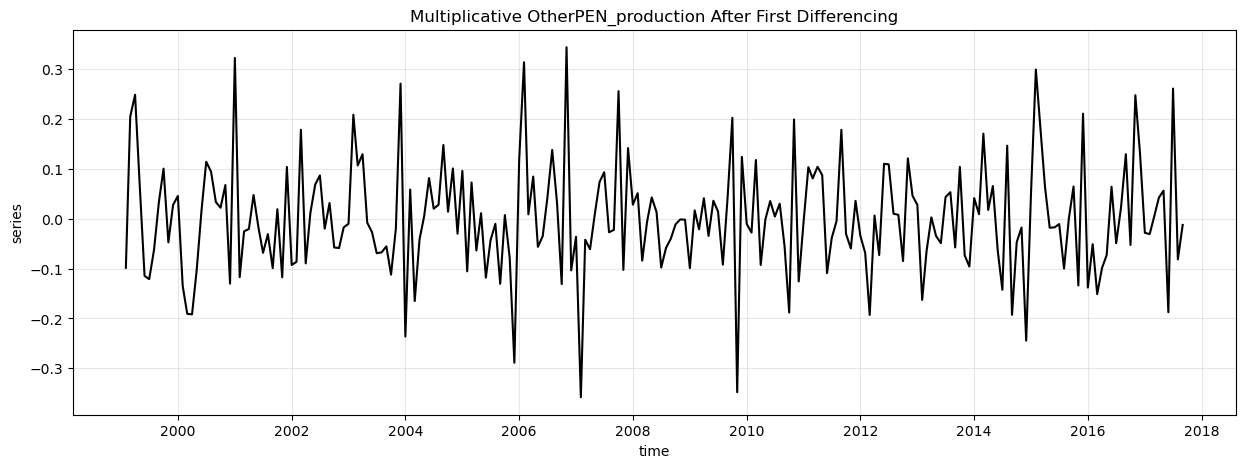

In [1219]:
multiplicative_diff_production_1 = OtherPEN_production['Log_production'].diff(PERIOD).diff(1)

run_sequence_plot(OtherPEN_production['Date'], multiplicative_diff_production_1,
                  title="Multiplicative OtherPEN_production After First Differencing")

In [1220]:
multiplicative_diff_production_1 = multiplicative_diff_production_1[1 + PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -7.196925016038069
p-value:  2.4210606324159005e-10


##### Second difference

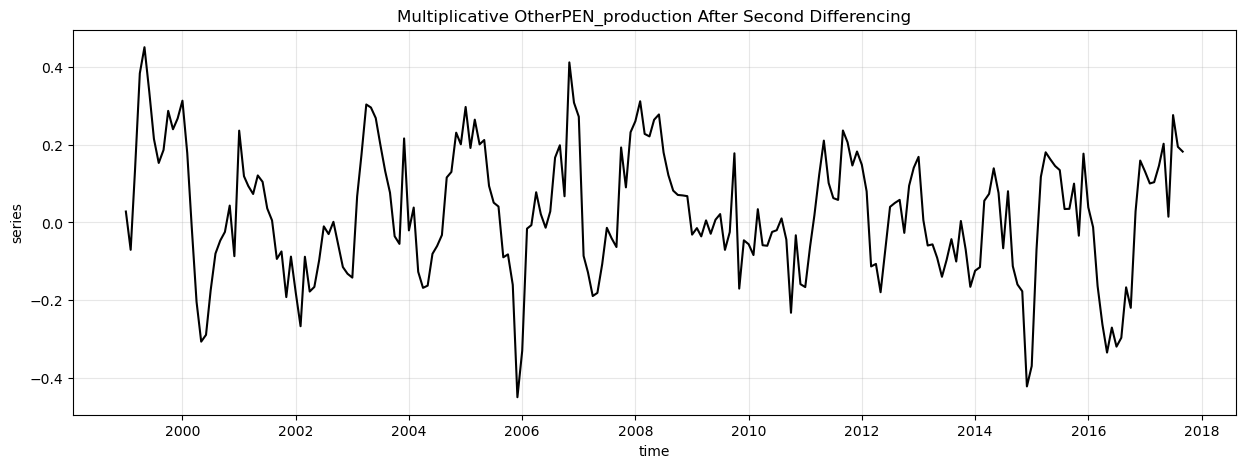

In [1221]:
multiplicative_diff_production_12 = OtherPEN_production['Log_production'].diff(PERIOD)

run_sequence_plot(OtherPEN_production['Date'], multiplicative_diff_production_12,
                  title="Multiplicative OtherPEN_production After Second Differencing")

In [1222]:
multiplicative_diff_production_12 = multiplicative_diff_production_12[PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -5.056301796553724
p-value:  1.71508374654496e-05


In [1223]:
data_to_return_to_initial_series = {
    'additive_decomposed_production': {
        'predicted_trend': additive_decomposed_trend_prediction,
        'seasonality': additive_decomposed_seasonal
    },
    'multiplicative_decomposed_production': {
        'predicted_trend': multiplicative_decomposed_trend_prediction,
        'seasonality': multiplicative_decomposed_seasonal
    },
    'additive_diff_production_1': {
        'lag': 1
    },
    'multiplicative_diff_production_1': {
        'lag': 1
    },
    'additive_diff_production_12': {
        'lag': PERIOD
    },
    'multiplicative_diff_production_12': {
        'lag': PERIOD
    }
}

#### Note!

All our result time series from approach 3 are stationary both for additive and multiplicative hypotheses.

<a id='section_4'></a>
## Section 4. Correlation analysis

In [1224]:
original_df

,Area_New,Area_ma,Area_ma_new,Area_npa,Area_rpa,Region,Year
0,0.0,0.0,0.000000,0.0,0.0,JH,1974
1,59.0,128.0,128.000000,187.0,0.0,JH,1975
2,59.0,147.0,147.000000,206.0,0.0,JH,1976
3,56.0,171.0,116.538462,227.0,0.0,JH,1977
4,59.0,191.0,93.423077,250.0,0.0,JH,1978
...,...,...,...,...,...,...,...
296,238.0,634.0,412.284615,765.0,21.0,OtherPEN,2012
297,238.0,639.0,386.253846,768.0,20.0,OtherPEN,2013
298,238.0,653.0,360.130769,774.0,18.0,OtherPEN,2014
299,238.0,671.0,346.976923,796.0,14.0,OtherPEN,2015


In [1225]:
# print plots for all columns in area_df
alt.Chart(pd.melt(area_df, "Year")).mark_line()\
    .encode(
    x = alt.X("Year:O"),
    y = alt.Y("value:Q")
).properties(width=800 / 2, height=800 / 4)\
    .facet(
    facet=alt.Facet("variable:N"),
    columns=2
).resolve_scale(y="independent", x="independent")


alt.FacetChart(...)

In [1226]:
OtherPEN_area_df = area_df.where(area_df['Region'] == 'OtherPEN')

# join only OtherPEN df with OtherPEN_area_df to avoid long joins of the initial full dataframes of all regions
OtherPEN_prod_features = pd.merge(OtherPEN_production, OtherPEN_area_df, on=["Year"], how='left')

In [1227]:
rainfall_df.Region.unique()

array(['Johor', 'Pahang', 'Perak', 'Other Pen. States', 'Peninsula',
       'Sabah', 'Sarawak'], dtype=object)

In [1228]:
# change column value as state name in rainfall_df and OtherPEN_prod_features is different
OtherPEN_prod_features.Region = 'Other Pen. States'

OtherPEN_prod_features = pd.merge(OtherPEN_prod_features, rainfall_df, on=['Year', 'Month', 'Region'], how='left')
OtherPEN_prod_features.drop('Region', inplace=True, axis=1)

for col_name in ['Area_New', 'Area_ma', 'Area_ma_new', 'Area_npa', 'Area_rpa', 'Rainfall']:
    OtherPEN_prod_features[col_name].fillna(OtherPEN_prod_features[col_name].mean(), inplace=True)

OtherPEN_prod_features

,index,Year,Month,Production,Date,Log_production,Area_New,Area_ma,Area_ma_new,Area_npa,Area_rpa,Rainfall
0,711,1998,1,89.690,1998-01-01,4.496359,238.0,506.000000,398.500000,562.000000,3.000000,157.849442
1,712,1998,2,112.724,1998-02-01,4.724942,238.0,506.000000,398.500000,562.000000,3.000000,159.374471
2,713,1998,3,113.573,1998-03-01,4.732446,238.0,506.000000,398.500000,562.000000,3.000000,118.394494
3,714,1998,4,113.454,1998-04-01,4.731397,238.0,506.000000,398.500000,562.000000,3.000000,99.763690
4,715,1998,5,119.671,1998-05-01,4.784746,238.0,506.000000,398.500000,562.000000,3.000000,182.705310
...,...,...,...,...,...,...,...,...,...,...,...,...
232,943,2017,5,211.911,2017-05-01,5.356166,238.0,599.526316,396.352227,693.578947,13.421053,237.855400
233,944,2017,6,180.407,2017-06-01,5.195215,238.0,599.526316,396.352227,693.578947,13.421053,167.523401
234,945,2017,7,232.763,2017-07-01,5.450021,238.0,599.526316,396.352227,693.578947,13.421053,159.524947
235,946,2017,8,238.452,2017-08-01,5.474168,238.0,599.526316,396.352227,693.578947,13.421053,285.581686


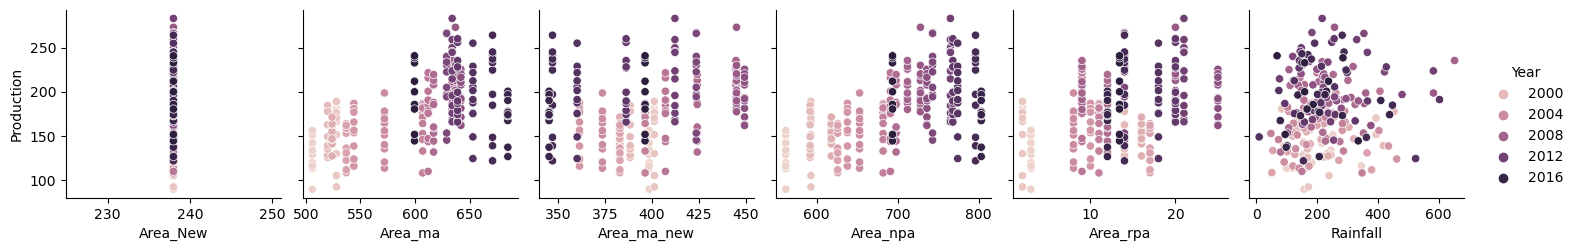

In [1229]:
sns.pairplot(OtherPEN_prod_features,
             x_vars=['Area_New', 'Area_ma', 'Area_ma_new', 'Area_npa', 'Area_rpa', 'Rainfall'],
             y_vars=['Production'],
             hue='Year'
             )

From the below analysis we can choose the best features which we can use for our DL and ML models. In my case this are **Area_npa** and **Area_ma**

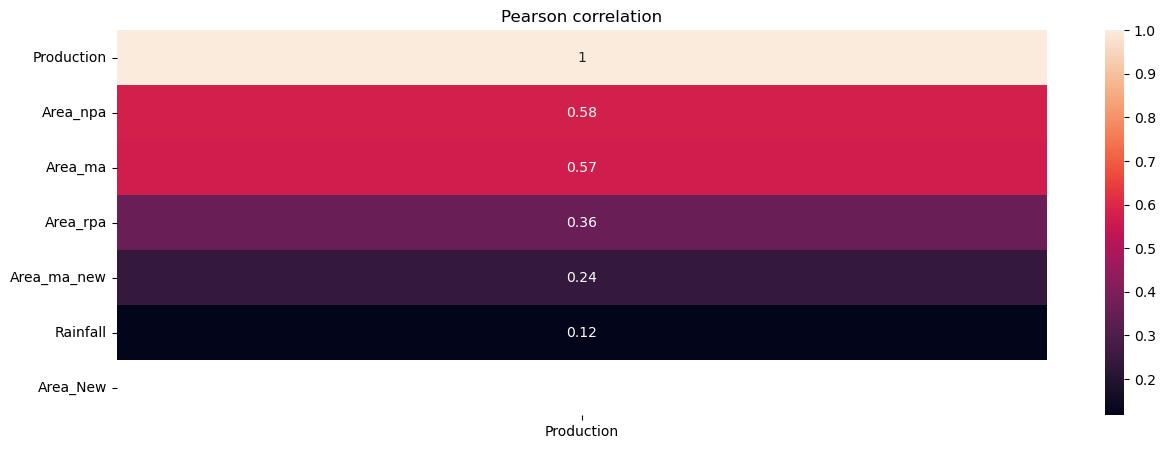

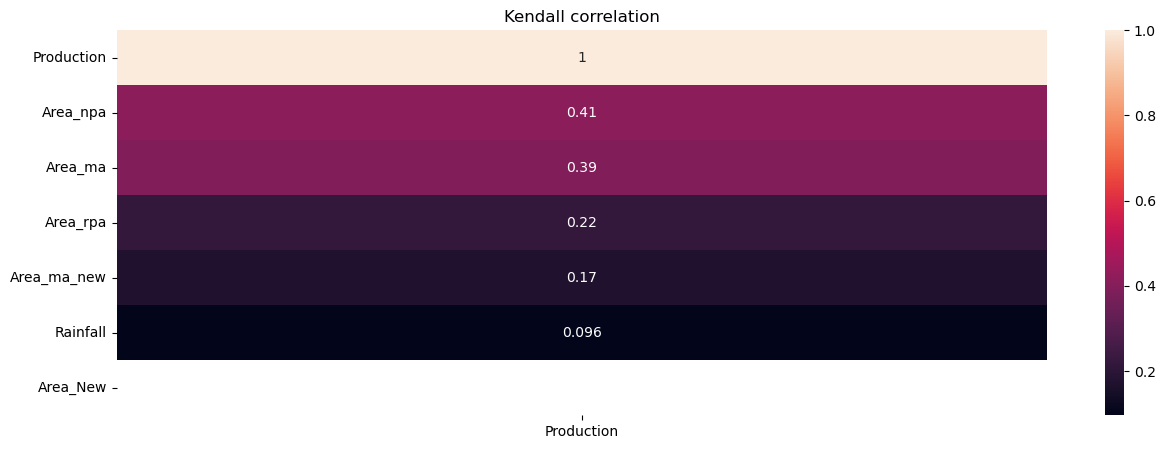

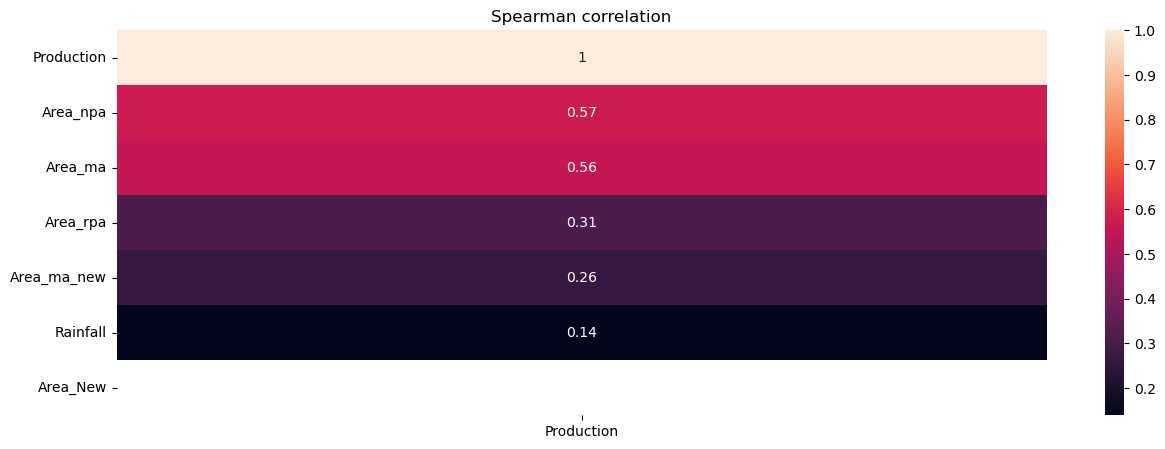

In [1230]:
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        OtherPEN_prod_features[['Production', 'Area_New', 'Area_ma', 'Area_ma_new', 'Area_npa', 'Area_rpa', 'Rainfall']].corr(method=method)[['Production']]\
            .sort_values(by='Production', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()

<a id='section_5'></a>
## Section 5. Feature generation and validation of DL models

In [42]:
import statsmodels.tsa.api as smt


def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE

    return({'1. Mean Absolute Percentage Error (MAPE)':mape,
            '2. Mean Percentage Error (MPE)': mpe,
            '3. Root Mean Squared Error (RMSE)': rmse})


def plots(data, lags=None):
    # define helper plot function for visualization
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [43]:
from sklearn.model_selection import TimeSeriesSplit


def get_train_validate_test_split(time_series):
    """

    :return: splits on train, validation and test sets based on Cross-Validation
    """
    n_splits = 3 #Number of train/cv/test folds
    results = []

    trainTestSplit = TimeSeriesSplit(n_splits+1, test_size=12).split(time_series)
    next(trainTestSplit) #Skip the first fold

    for trainCvIndices, testIndices in trainTestSplit:
        # First, we split Train + CV and Test
        XTrainCv = time_series.iloc[trainCvIndices]
        XTest = time_series.iloc[testIndices]

        # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
        testLength = len(XTest)
        train = XTrainCv.iloc[0: -testLength]
        validate = XTrainCv.iloc[-testLength: ]

        results.append([train, validate, XTest, XTrainCv])

    return results


In [44]:
def return_to_initial_series_additive_differencing(best_ARMA_model_prediction, len_train_set, order_tpl, stationary_series_name,
                                                   model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + PERIOD
    lag = data_to_return_to_initial_series[stationary_series_name]['lag']

    best_ARMA_model_prediction = best_ARMA_model_prediction.reset_index(drop=True)
    ARMA_model_prediction_initial_series = []

    for i in range(lag):
        ARMA_model_prediction_initial_series.append(OtherPEN_production.Production[len_train_set - lag + i + SHIFT] + best_ARMA_model_prediction[i])

    for i in range(lag, len(best_ARMA_model_prediction)):
        ARMA_model_prediction_initial_series.append(ARMA_model_prediction_initial_series[i - lag] +
                                                    best_ARMA_model_prediction[i])

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    model_forecast_accuracy = forecast_accuracy(ARMA_model_prediction_initial_series,
                                                OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT].to_numpy())
    print('Order -- ', order_tpl)
    pprint(model_forecast_accuracy)

    if show_plots:
        x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

        # add + 1 to make consistent plot
        plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], 'b--', label="train")
        plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', linestyle="--", label="test")
        plt.plot(x_indices, ARMA_model_prediction_initial_series, 'r--', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {order_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return ARMA_model_prediction_initial_series, model_forecast_accuracy


def return_to_initial_series_decomposed(best_model_prediction, len_train_set, order_tpl, stationary_series_name,
                                                 model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + PERIOD

    if 'additive' in stationary_series_name:
        model_prediction_initial_series = best_model_prediction +\
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + SHIFT: end_idx + SHIFT].values +\
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]
    else:
        model_prediction_initial_series = best_model_prediction *\
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + SHIFT: end_idx + SHIFT].values *\
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    model_forecast_accuracy = forecast_accuracy(model_prediction_initial_series,
                                                OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT].to_numpy())
    print('Order -- ', order_tpl)
    pprint(model_forecast_accuracy)

    if show_plots:
        x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

        # add + 1 to make consistent plot
        plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], color='blue', label="train")
        plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
        plt.plot(x_indices, model_prediction_initial_series, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {order_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return model_prediction_initial_series, model_forecast_accuracy

In [45]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape
    [n_samples, time_steps, features]
    """

    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)


In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
RAINFALL_LAGS = [i for i in range(12, 19)]
STATIONARY_PRODUCTION_LAGS = [i for i in range(1, 7)]

In [48]:
REGIONS = [['JH', 'Johor', 'JH'],
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'],
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

In [49]:
def process_data(production, rainfall, area, stationary_series, REGIONS, STATIONARY_PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    region = REGIONS[3]

    data = production[production.Region == region[0]]
    data = pd.merge(data[['Year', 'Month', 'Production']],
                    rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']],
                    on=['Year', 'Month'], how='left')

    data = pd.merge(data, area[area.Region == region[2]][
        ['Year', 'Area_ma', 'Area_npa']], on='Year', how='left')

    data['Year'] = data['Year'].astype(int)
    data['Month'] = data['Month'].astype(int)
    data.reset_index(inplace=True)

    data = data[SHIFT: -SHIFT].reset_index(drop=True)
    data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                   inplace=True)

    data.drop(['index', 'Year'], axis=1, inplace=True)

    for lag in RAINFALL_LAGS:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
        data['Rainfall_{0}'.format(lag)] = temp

    for lag in STATIONARY_PRODUCTION_LAGS:
        # add Nan values at the end during concatenation as we had a SHIFT after converting our series to stationary
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), stationary_series.values[:-lag]))
        data['Stationary_Production_{0}'.format(lag)] = temp

    PRODUCTION = stationary_series
    data.drop(['Production'], axis=1, inplace=True)

    data.fillna(data.mean(), inplace=True)

    #  And finally drop rainfalls
    data.drop(['Rainfall'], axis=1, inplace=True)
    PRODUCTION.index = data.index

    output[region[1]] = (data[max(RAINFALL_LAGS):], PRODUCTION[max(RAINFALL_LAGS):])
    return output


### Fit DL models

In [50]:
def fit_SimpleRNN_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit SimpleRNN to data train_X, train_y with features

    """
    hidden_units, batch_size, epochs = params

    # initialize model
    model = Sequential()

    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(SimpleRNN(hidden_units, input_shape=(train_X.shape[1], 1)))
    model.add(Dropout(0.2))

    # add an output layer to make final predictions
    model.add(Dense(1, activation='relu'))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        history = model.fit(train_X, train_y,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(validate_X, validate_y),
                            verbose=0, shuffle=False)

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model.fit(train_X, train_y,
                    epochs=epochs, batch_size=batch_size,
                    verbose=0, shuffle=False)

    return model


def fit_LSTM_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit LSTM to data train_X, train_y

    """
    hidden_units, batch_size, epochs = params

    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        history = model.fit(train_X, train_y,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(validate_X, validate_y),
                            verbose=0, shuffle=False)

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'][1:])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model.fit(train_X, train_y,
                      epochs=epochs, batch_size=batch_size,
                      verbose=0, shuffle=False)

    return model


In [51]:
def fit_Conv1d_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit Conv1d to data train_X, train_y

    """
    filters, batch_size, epochs = params
    optimizer = Adagrad(0.01)

    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=filters, kernel_size=2, activation='relu',
                         input_shape=(train_X.shape[1], train_X.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(50, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mse', optimizer=optimizer)

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        history = model_cnn.fit(train_X, train_y,
                                epochs=epochs, batch_size=batch_size,
                                validation_data=(validate_X, validate_y),
                                verbose=0, shuffle=False)

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'][1:])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model_cnn.fit(train_X, train_y,
                      epochs=epochs, batch_size=batch_size,
                      verbose=0, shuffle=False)

    return model_cnn


In [52]:
def get_train_validate_test_splits_for_DL(values):
    end_shift = max(RAINFALL_LAGS)
    train_lengths = [177 - end_shift, 189 - end_shift, 201 - end_shift]
    validate_length = PERIOD # also equal to test length

    splits = []
    for train_length in train_lengths:
        train = values[: train_length, :]
        validate = values[train_length: train_length + validate_length, :]
        train_validate = values[:train_length + validate_length, :]
        test = values[train_length + validate_length: train_length + 2 * validate_length, :]

        splits.append((train, validate, test, train_validate))

    return splits


def reshape_for_model(model_name, dataset):
    if 'LSTM' in model_name or\
        'RNN' in model_name or\
        'Conv1d' in model_name:

        if 'LSTM' in model_name:
            # reshape input to be 3D [samples, features, timesteps]
            dataset = dataset.reshape((dataset.shape[0], 1, dataset.shape[1]))

        else:
            # reshape input to be 3D [samples, timesteps, features]
            dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1))

    return dataset


def reshape_test_set_for_model(model_name, test_X):
    if 'LSTM' in model_name or\
        'RNN' in model_name or\
        'Conv1d' in model_name:

        if 'LSTM' in model_name:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        else:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

    return test_X


def test_model_with_transform(model, test_X, model_name, first_row_idx):
    """

    Use previous predicted value to construct our feature dataframe and use it for next value prediction
    """
    yhat = []

    test_X = reshape_test_set_for_model(model_name, test_X)

    test_row = test_X[first_row_idx]
    prod_lags = test_row[-len(STATIONARY_PRODUCTION_LAGS):]
    test_row = test_row.reshape((1, len(test_row)))
    test_row = reshape_for_model(model_name, test_row)
    for i in range(len(test_X)):
        yhat_one_pred = model.predict(test_row)
        yhat.append(yhat_one_pred[0])
        
        test_row = test_X[i]

        prod_lags = np.roll(prod_lags, 1)
        prod_lags[0] = yhat_one_pred
        new_test_row = np.concatenate((test_row[:-len(STATIONARY_PRODUCTION_LAGS)], prod_lags), axis=0)
        test_row = new_test_row.reshape((1, len(new_test_row)))
        test_row = reshape_for_model(model_name, test_row)
    
    yhat = np.array(yhat)
    yhat[yhat<0] = 0
    return yhat


In [53]:
def optimize_DL_feature_models(order_list, stationary_series_name, model_name, full_df_split, SCALER, show_plots, debug_mode):
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 100_000
    best_model = dict()

    train, validate, test, train_validate = full_df_split

    train_X, train_y = train[:, :-1], train[:, -1]
    validate_X, validate_y = validate[:, :-1], validate[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_validate_X, train_validate_y = train_validate[:, :-1], train_validate[:, -1]

    if 'LSTM' in model_name:
        # reshape input to be 3D [samples, features, timesteps]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        validate_X = validate_X.reshape((validate_X.shape[0], 1, validate_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        train_validate_X = train_validate_X.reshape((train_validate_X.shape[0], 1, train_validate_X.shape[1]))

    else:
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
        validate_X = validate_X.reshape((validate_X.shape[0], validate_X.shape[1], 1))
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
        train_validate_X = train_validate_X.reshape((train_validate_X.shape[0], train_validate_X.shape[1], 1))

    # find the best orders for the model based on validation set
    best_model['order'] = order_list[0]
    for order in order_list:
        if 'Conv1d' in model_name:
            model = fit_Conv1d_features(train_X, train_y, validate_X, validate_y, order, False)
        elif 'LSTM' in model_name:
            model = fit_LSTM_features(train_X, train_y, validate_X, validate_y, order, False)
        else:
            model = fit_SimpleRNN_features(train_X, train_y, validate_X, validate_y, order, False)

        yhat = test_model_with_transform(model, validate_X, model_name, 0)
        model_forecast_accuracy = forecast_accuracy(yhat, validate_y)
        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Order -- ', order)
            pprint(model_forecast_accuracy)

        # weighted_score
        weighted_score = 0.5 * (model_forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (model_forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['order'] = order
            best_model['prediction'] = yhat
            best_model['model_accuracy'] = model_forecast_accuracy

    # make a prediction
    if 'LSTM' in model_name:
        test_model = fit_LSTM_features(train_validate_X, train_validate_y, None, None, best_model['order'], True)
        yhat = test_model_with_transform(test_model, test_X, model_name, 0)
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    else:
        if 'Conv1d' in model_name:
            test_model = fit_Conv1d_features(train_validate_X, train_validate_y, None, None, best_model['order'], True)
        else:
            test_model = fit_SimpleRNN_features(train_validate_X, train_validate_y, None, None, best_model['order'], True)

        yhat = test_model_with_transform(test_model, test_X, model_name, 0)
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

    if show_plots:
        plt.plot(test_y, color='orange', label="test")
        plt.plot(yhat, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} on TEST set with orders order -- {best_model["order"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, yhat), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # return to initial series
    best_model_test_accuracy = dict()
    best_model_prediction_initial_series = []
    if 'decomposed' in stationary_series_name:
        best_model_prediction_initial_series, best_model_test_accuracy =\
            return_to_initial_series_decomposed(inv_yhat, len(train_validate_y) + max(RAINFALL_LAGS), best_model['order'],
                                                stationary_series_name, model_name, show_plots)

    # In this lab I decided to stay decomposed stationary series as they showed the best performance during my testing and
    # also them showed the best performance for HW_1. In such a way I also reduce time to run this notebok by yourself.
    # else:
    #     if 'multiplicative' in stationary_series_name:
    #         inv_yhat = np.exp(inv_yhat)
    #
    #     best_model_prediction_initial_series, best_model_test_accuracy =\
    #         return_to_initial_series_additive_differencing(inv_yhat, len(train_validate_y) + max(RAINFALL_LAGS), best_model['order'],
    #                                                        stationary_series_name, model_name, show_plots)

    return best_model_prediction_initial_series, best_model['order'], best_model_test_accuracy


In [54]:
def fit_Random_Forest(params):
    model = RandomForestRegressor(
        n_estimators=params[0],
        max_depth=params[1],
        random_state=0
    )
    return model


def fit_XGBoost(params):
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=params[0],
        max_depth=params[1],
        min_child_weight=params[2]
    )
    return model

In [55]:
def optimize_ML_feature_models(order_list, stationary_series_name, model_name, full_df_split, SCALER, show_plots, debug_mode):
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 100_000
    best_model = dict()

    train, validate, test, train_validate = full_df_split

    train_X, train_y = train[:, :-1], train[:, -1]
    validate_X, validate_y = validate[:, :-1], validate[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_validate_X, train_validate_y = train_validate[:, :-1], train_validate[:, -1]

    # find the best orders for the model based on validation set
    best_model['order'] = order_list[0]
    for order in order_list:
        if 'Random Forest' in model_name:
            model = fit_Random_Forest(order)
        else:
            model = fit_XGBoost(order)

        model.fit(train_X, train_y)
        yhat = test_model_with_transform(model, validate_X, model_name, 0)
        yhat_2D = yhat[:, np.newaxis]
        model_forecast_accuracy = forecast_accuracy(yhat_2D, validate_y)
        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Order -- ', order)
            pprint(model_forecast_accuracy)

        # weighted_score
        weighted_score = 0.5 * (model_forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (model_forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['order'] = order
            best_model['prediction'] = yhat
            best_model['model_accuracy'] = model_forecast_accuracy

    # make a prediction
    if 'Random Forest' in model_name:
        test_model = fit_Random_Forest(best_model['order'])
    else:
        test_model = fit_XGBoost(best_model['order'])

    test_model.fit(train_validate_X, train_validate_y)
    yhat = test_model_with_transform(test_model, test_X, model_name, 0)

    if show_plots:
        plt.plot(test_y, color='orange', label="test")
        plt.plot(yhat, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} on TEST set with orders order -- {best_model["order"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # invert scaling for forecast
    yhat_2D = yhat[:, np.newaxis]
    inv_yhat = np.concatenate((test_X, yhat_2D), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # return to initial series
    best_model_test_accuracy = dict()
    best_model_prediction_initial_series = []
    if 'decomposed' in stationary_series_name:
        best_model_prediction_initial_series, best_model_test_accuracy =\
            return_to_initial_series_decomposed(inv_yhat, len(train_validate_y) + max(RAINFALL_LAGS), best_model['order'],
                                                stationary_series_name, model_name, show_plots)

    return best_model_prediction_initial_series, best_model['order'], best_model_test_accuracy


In [56]:
def get_best_DL_model(stationary_series_name, full_df_split, SCALER, show_plots, debug_mode):
    # RF_n_estimators = [100, 500, 1000]
    # RF_max_depth = [80, 90, 100]
    # RF_orders = [RF_n_estimators, RF_max_depth]
    # RF_orders = list(itertools.product(*RF_orders))

    # !!!! you can uncomment previous line and commend the next line for params validation,
    # but for reducing time to run this notebook by youself I stayed only the best parameters
    RF_orders = [[100, 100], [1000, 100]]
    best_RF_model_prediction, RF_model_description, RF_forecast_accuracy = optimize_ML_feature_models(RF_orders, stationary_series_name,
                                                                                                         'Random Forest features', full_df_split, SCALER,
                                                                                                         show_plots, debug_mode)

    # XGB_n_estimators = [100, 500, 1000]
    # XGB_max_depth = [4, 5, 6]
    # XGB_min_child_weight = [1, 2, 4]
    # XGB_orders = [XGB_n_estimators, XGB_max_depth, XGB_min_child_weight]
    # XGB_orders = list(itertools.product(*XGB_orders))
    XGB_orders = [[100, 4, 1]]
    best_XGB_model_prediction, XGB_model_description, XGB_forecast_accuracy = optimize_ML_feature_models(XGB_orders, stationary_series_name,
                                                                                                         'XGBoost features', full_df_split, SCALER,
                                                                                                         show_plots, debug_mode)

    # RNN_filters_lst = [20, 30, 40]
    # RNN_batch_size_lst = [12, 32, 64]
    # RNN_epochs_lst = [400]
    # RNN_orders = [RNN_filters_lst, RNN_batch_size_lst, RNN_epochs_lst]
    # RNN_orders = list(itertools.product(*RNN_orders))
    RNN_orders = [[20, 32, 400]] # best

    best_RNN_model_prediction, RNN_model_description, RNN_forecast_accuracy = optimize_DL_feature_models(RNN_orders, stationary_series_name,
                                                                                                          'RNN features', full_df_split, SCALER,
                                                                                                         show_plots, debug_mode)

    # LSTM_units_lst = [20, 30, 40]
    # LSTM_batch_size_lst = [12, 32, 64]
    # LSTM_epochs_lst = [400]
    # LSTM_orders = [LSTM_units_lst, LSTM_batch_size_lst, LSTM_epochs_lst]
    # LSTM_orders = list(itertools.product(*LSTM_orders))
    LSTM_orders = [[20, 12, 400]]

    best_LSTM_model_prediction, LSTM_model_description, LSTM_forecast_accuracy = optimize_DL_feature_models(LSTM_orders, stationary_series_name,
                                                                                                            'LSTM features', full_df_split, SCALER,
                                                                                                             show_plots, debug_mode)

    # Conv1d_filters_lst = [20, 30, 40]
    # Conv1d_batch_size_lst = [12, 32, 64]
    # Conv1d_epochs_lst = [400]
    # Conv1d_orders = [Conv1d_filters_lst, Conv1d_batch_size_lst, Conv1d_epochs_lst]
    # Conv1d_orders = list(itertools.product(*Conv1d_orders))
    Conv1d_orders = [[20, 12, 400], [30, 64, 400]]

    best_Conv1d_model_prediction, Conv1d_model_description, Conv1d_forecast_accuracy = optimize_DL_feature_models(Conv1d_orders, stationary_series_name,
                                                                                                                  'Conv1d features', full_df_split, SCALER,
                                                                                                                  show_plots, debug_mode)

    best_model = {'model_name': None, 'model_prediction': None, 'order': None}
    min_weighted_score = 100
    for forecast_accuracy, model_name, model_prediction, model_description in\
            [
                (RF_forecast_accuracy, 'Random Forest', best_RF_model_prediction, RF_model_description),
                (XGB_forecast_accuracy, 'XGBoost', best_XGB_model_prediction, XGB_model_description),
                (RNN_forecast_accuracy, 'SimpleRNN', best_RNN_model_prediction, RNN_model_description),
                (LSTM_forecast_accuracy, 'LSTM', best_LSTM_model_prediction, LSTM_model_description),
                (Conv1d_forecast_accuracy, 'Conv1d model', best_Conv1d_model_prediction, Conv1d_model_description),
            ]:
        weighted_score = 0.5 * (forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['model_name'] = model_name
            best_model['model_prediction'] = model_prediction
            best_model['order'] = model_description

            best_model['1. Mean Absolute Percentage Error (MAPE)'] = forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)']
            best_model['2. Mean Percentage Error (MPE)'] = forecast_accuracy['2. Mean Percentage Error (MPE)']
            best_model['3. Root Mean Squared Error (RMSE)'] = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

    return best_model, len(full_df_split[3]) + max(RAINFALL_LAGS)


In [57]:
def create_feature_df_for_stationary(stationary_series):
    data = process_data(production_df, rainfall_df, area_df, stationary_series,
                        REGIONS, STATIONARY_PRODUCTION_LAGS, RAINFALL_LAGS)
    feature_values = np.concatenate((data['Other Pen. States'][0].values, data['Other Pen. States'][1].values.reshape((-1, 1))), axis=1)
    SCALER = MinMaxScaler(feature_range=(0, 1))
    scaled_values = SCALER.fit_transform(feature_values)

    return scaled_values, SCALER


In [1247]:
def test_ML_DL_models(stationary_series, stationary_series_name, show_plots, debug_mode):
    full_numpy_arrs, SCALER = create_feature_df_for_stationary(stationary_series)
    full_df_splits = get_train_validate_test_splits_for_DL(full_numpy_arrs)

    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Orders',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    for i in range(3):
        full_df_split = full_df_splits[i]

        best_model, last_train_set_idx = get_best_DL_model(stationary_series_name, full_df_split, SCALER, show_plots, debug_mode)
        results_df.loc[i] = [i + 1, stationary_series_name,
                             best_model['model_name'], best_model['order'],
                             best_model['1. Mean Absolute Percentage Error (MAPE)'],
                             best_model['2. Mean Percentage Error (MPE)'],
                             best_model['3. Root Mean Squared Error (RMSE)']]

        start_idx = last_train_set_idx
        end_idx = last_train_set_idx + PERIOD
        x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

        # add + 1 to make consistent plot
        plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], color='blue', label="train")
        plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
        plt.plot(x_indices, best_model['model_prediction'], color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'[{stationary_series_name}] Best Prediction on Test Dataset -- {best_model["model_name"]} {best_model["order"]}')
        plt.grid(alpha=0.3)
        plt.show()

    return results_df

############################################################ Random Forest features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.10459367080307497,
 '2. Mean Percentage Error (MPE)': 0.06141800533036152,
 '3. Root Mean Squared Error (RMSE)': 20.768533756217895}
############################################################ XGBoost features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 4, 1]
{'1. Mean Absolute Percentage Error (MAPE)': 0.1334602803177524,
 '2. Mean Percentage Error (MPE)': 0.08332907762805729,
 '3. Root Mean Squared Error (RMSE)': 27.36797137737506}
############################################################ RNN features ############################################################ 


Best validation loss 

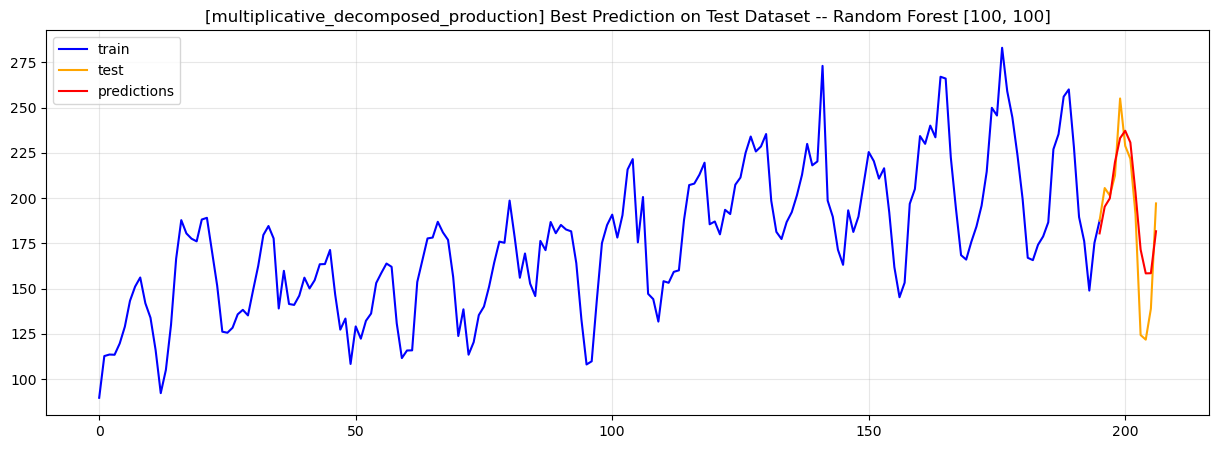

############################################################ Random Forest features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.09038137532779862,
 '2. Mean Percentage Error (MPE)': 0.006600571396691635,
 '3. Root Mean Squared Error (RMSE)': 18.881214370539507}
############################################################ XGBoost features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 4, 1]
{'1. Mean Absolute Percentage Error (MAPE)': 0.08351931066546837,
 '2. Mean Percentage Error (MPE)': 0.00999647596445725,
 '3. Root Mean Squared Error (RMSE)': 17.814746640328984}
############################################################ RNN features ############################################################ 


Best validation lo

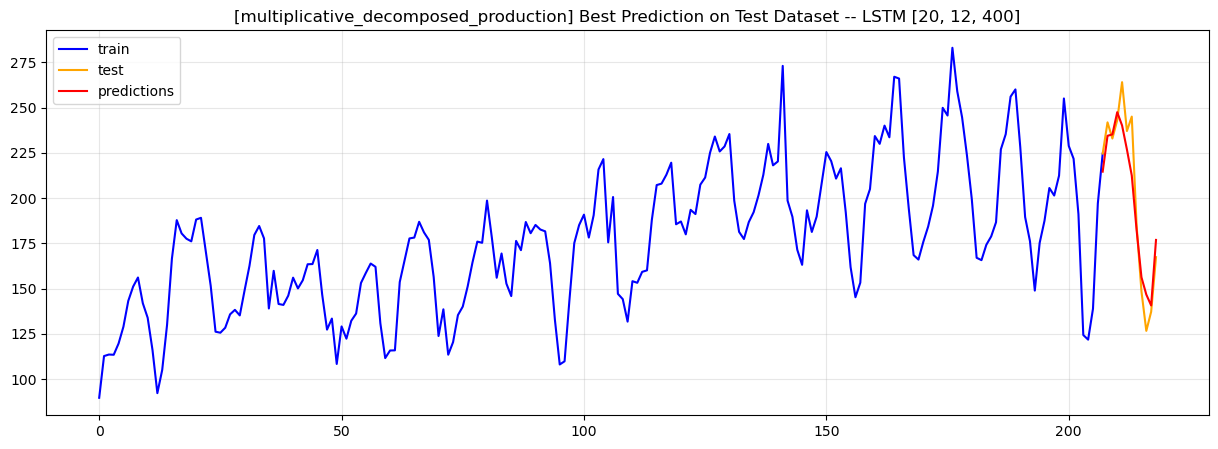

############################################################ Random Forest features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [1000, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.1334491900070337,
 '2. Mean Percentage Error (MPE)': 0.12458698245429793,
 '3. Root Mean Squared Error (RMSE)': 29.832445083941664}
############################################################ XGBoost features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 4, 1]
{'1. Mean Absolute Percentage Error (MAPE)': 0.13367342497476012,
 '2. Mean Percentage Error (MPE)': 0.12181692174995157,
 '3. Root Mean Squared Error (RMSE)': 29.934821048647066}
############################################################ RNN features ############################################################ 


Best validation los

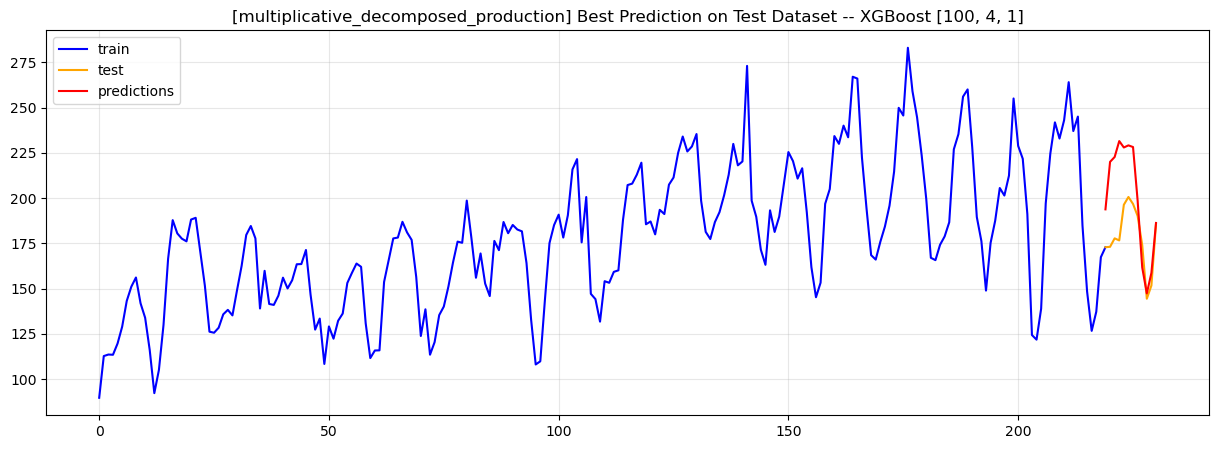

,Iteration,Stationary_Series_Name,Model_Name,Model_Orders,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,multiplicative_decomposed_production,Random Forest,"[100, 100]",0.104594,0.061418,20.768534
1,2,multiplicative_decomposed_production,LSTM,"[20, 12, 400]",0.056375,-0.002823,14.397626
2,3,multiplicative_decomposed_production,XGBoost,"[100, 4, 1]",0.133673,0.121817,29.934821


In [1248]:
multiplicative_ML_DL_results_df = test_ML_DL_models(multiplicative_decomposed_production, 'multiplicative_decomposed_production', False, False)
multiplicative_ML_DL_results_df

############################################################ Random Forest features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.12726628232484993,
 '2. Mean Percentage Error (MPE)': 0.07575339878524635,
 '3. Root Mean Squared Error (RMSE)': 24.440131092893964}
############################################################ XGBoost features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 4, 1]
{'1. Mean Absolute Percentage Error (MAPE)': 0.1340354231203333,
 '2. Mean Percentage Error (MPE)': 0.07885325895692287,
 '3. Root Mean Squared Error (RMSE)': 25.550346309175378}
############################################################ RNN features ############################################################ 


Best validation loss

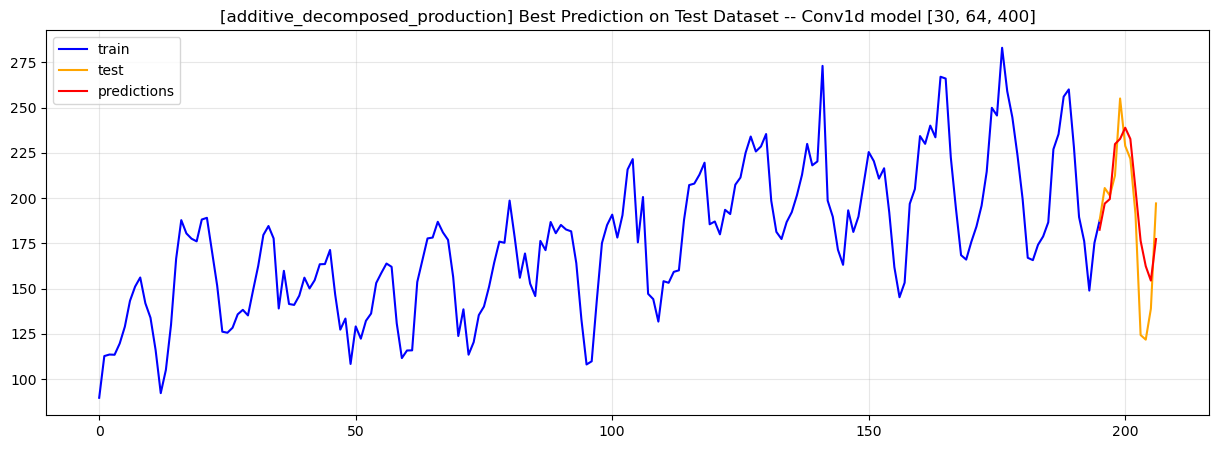

############################################################ Random Forest features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.07905589517635024,
 '2. Mean Percentage Error (MPE)': -0.003504833953872215,
 '3. Root Mean Squared Error (RMSE)': 17.76862115408836}
############################################################ XGBoost features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 4, 1]
{'1. Mean Absolute Percentage Error (MAPE)': 0.05864371662186121,
 '2. Mean Percentage Error (MPE)': -0.021910268928580084,
 '3. Root Mean Squared Error (RMSE)': 15.09920469620694}
############################################################ RNN features ############################################################ 


Best validation l

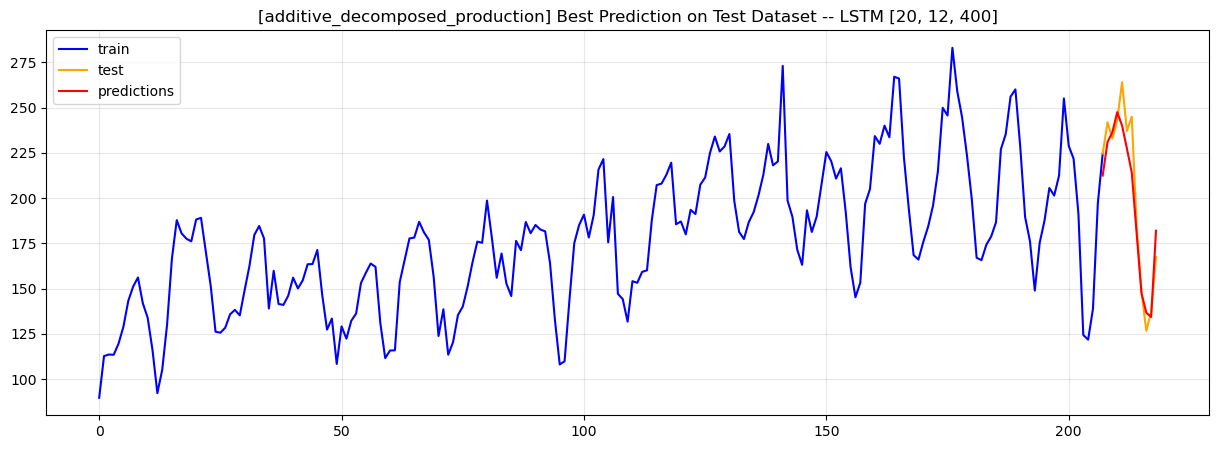

############################################################ Random Forest features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [1000, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.13832314483065786,
 '2. Mean Percentage Error (MPE)': 0.11943807944618395,
 '3. Root Mean Squared Error (RMSE)': 31.766511427845696}
############################################################ XGBoost features ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 4, 1]
{'1. Mean Absolute Percentage Error (MAPE)': 0.14423103245177543,
 '2. Mean Percentage Error (MPE)': 0.13532863422240177,
 '3. Root Mean Squared Error (RMSE)': 32.72905001760174}
############################################################ RNN features ############################################################ 


Best validation los

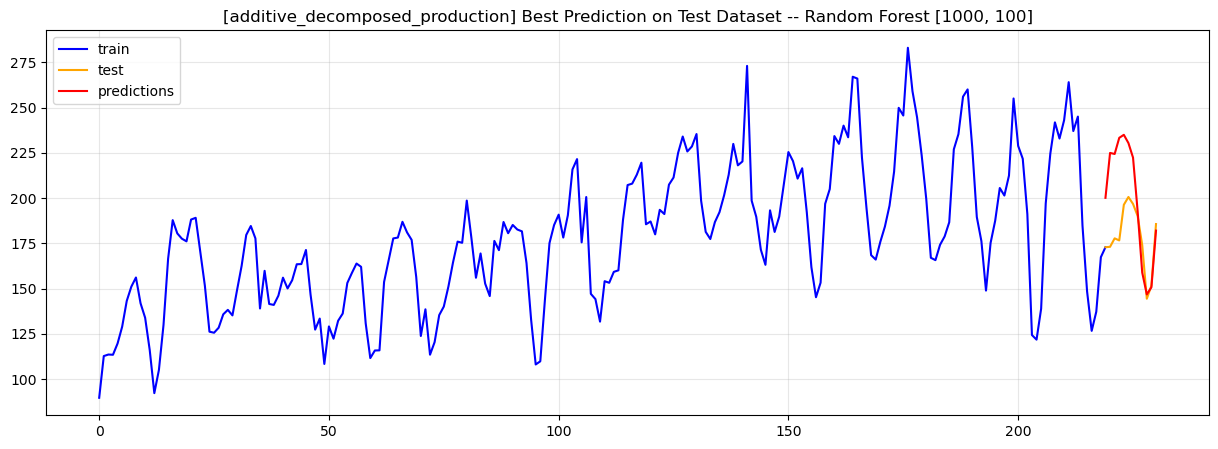

,Iteration,Stationary_Series_Name,Model_Name,Model_Orders,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,additive_decomposed_production,Conv1d model,"[30, 64, 400]",0.114711,0.070459,22.908938
1,2,additive_decomposed_production,LSTM,"[20, 12, 400]",0.050527,-0.017167,13.735057
2,3,additive_decomposed_production,Random Forest,"[1000, 100]",0.138323,0.119438,31.766511


In [1249]:
additive_ML_DL_results_df = test_ML_DL_models(additive_decomposed_production, 'additive_decomposed_production', False, False)
additive_ML_DL_results_df

<a id='section_6'></a>
## Section 6. Fbprophet and Nbeats models

### Usage of Facebook Prophet Library

In [1250]:
def fit_Prophet(train_dates, train_vals, params):
    m = Prophet(seasonality_mode=params[0],
                growth=params[1],
                yearly_seasonality=True,
                daily_seasonality=True)

    m.add_country_holidays(country_name='US')
    m.add_seasonality(name='monthly', period=PERIOD, fourier_order=params[2])

    ptrain = pd.DataFrame()
    ptrain["ds"] = train_dates
    ptrain["y"] = train_vals

    ptrain['floor'] = ptrain['y'].min()
    ptrain['cap'] = ptrain['y'].max()

    m.fit(ptrain)
    return m, ptrain

In [1251]:
def get_train_validate_test_splits_for_Prophet(production_ts):
    train_lengths = [201 - max(RAINFALL_LAGS)]
    validate_length = PERIOD # also equal to test length

    splits = []
    for train_length in train_lengths:
        train = (production_ts.index[: train_length], production_ts.values[: train_length])
        validate = (production_ts.index[train_length: train_length + validate_length], production_ts.values[train_length: train_length + validate_length])
        train_validate = (production_ts.index[:train_length + validate_length], production_ts.values[:train_length + validate_length])
        test = (production_ts.index[train_length + validate_length: train_length + 2 * validate_length],
                production_ts.values[train_length + validate_length: train_length + 2 * validate_length])

        splits.append((train, validate, test, train_validate))

    return splits

In [1252]:
def optimize_Prophet_model(order_list, stationary_series_name, model_name, full_df_split,
                           show_plots, debug_mode):
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 100
    best_model = dict()

    train, validate, test, train_valid = full_df_split
    X_test, y_test = test
    X_train_valid, y_train_valid = train_valid

    val_interval = PERIOD

    # find the best orders for the model based on validation set
    best_model['order'] = order_list[0]
    for order in order_list:
        model, ptrain = fit_Prophet(X_train_valid, y_train_valid, order)
        cutoffs = pd.to_datetime(['2013-03-01', '2014-03-01', '2015-03-01'])
        df_cv = cross_validation(model, cutoffs=cutoffs, horizon='365 days', disable_tqdm=True)
        df_p = performance_metrics(df_cv, rolling_window=1)
        model_forecast_accuracy = df_p['mape'][0]

        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Order -- ', order)
            print(df_p)

        if model_forecast_accuracy <= min_weighted_score:
            min_weighted_score = model_forecast_accuracy
            best_model['order'] = order
            best_model['prediction'] = df_cv
            best_model['model_accuracy'] = model_forecast_accuracy

    if show_plots:
        plt.plot(best_model['prediction']['ds'], best_model['prediction']['y'], color='orange', label="test")
        plt.plot(best_model['prediction']['ds'], best_model['prediction']['yhat'], color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} with orders order -- {best_model["order"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # test our model
    test_model, ptrain = fit_Prophet(X_train_valid, y_train_valid, best_model['order'])
    future = test_model.make_future_dataframe(periods=val_interval, include_history=True, freq="m")
    future['floor'] = ptrain['y'].min()
    future['cap'] = ptrain['y'].max()

    forecast = test_model.predict(future)

    y_test_pred = forecast[["yhat"]][-PERIOD:].values.flatten()

    # return to initial series
    start_idx = len(y_train_valid) + max(RAINFALL_LAGS)
    end_idx = start_idx + PERIOD
    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    best_model_test_accuracy = forecast_accuracy(y_test_pred,
                                                OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT].to_numpy())
    pprint(best_model_test_accuracy)

    x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

    # add + 1 to make consistent plot
    plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], color='blue', label="train")
    plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
    plt.plot(x_indices, y_test_pred, color='red', label="predictions")
    plt.legend(loc='upper left')
    plt.title(f'{model_name} {best_model["order"]} Prediction on Test Dataset')
    plt.grid(alpha=0.3)
    plt.show()

    # In this lab I decided to stay decomposed stationary series as they showed the best performance during my testing and
    # also them showed the best performance for HW_1. In such a way I also reduce time to run this notebok by yourself.

    # else:
    #     if 'multiplicative' in stationary_series_name:
    #         prediction = np.exp(prediction)
    #
    #     best_model_prediction_initial_series, best_model_test_accuracy =\
    #         return_to_initial_series_additive_differencing(prediction, len(train_validate_set),
    #                                                        best_model['(p, d, q)'], stationary_series_name, model_name, show_plots)

    return y_test_pred, best_model['order'], best_model_test_accuracy

In [1253]:
def test_Prophet_model(full_df, series_name, show_plots, debug_mode):
    full_df_split = get_train_validate_test_splits_for_Prophet(full_df)[0]

    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Orders',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    # seasonality_mode_lst = ['additive', 'multiplicative']
    # growth_lst = ['linear', 'logistic']
    # fourier_order_lst = [3, 4, 5]
    # order_list = [seasonality_mode_lst, growth_lst, fourier_order_lst]
    # order_list = list(itertools.product(*order_list))
    order_list = [['multiplicative', 'linear', 4]]

    best_model_prediction_initial_series, best_model_order, best_model_test_accuracy =\
        optimize_Prophet_model(order_list, series_name, 'FBProphet', full_df_split, show_plots, debug_mode)
    results_df.loc[i] = [3, series_name,
                         'FBProphet', best_model_order,
                         best_model_test_accuracy['1. Mean Absolute Percentage Error (MAPE)'],
                         best_model_test_accuracy['2. Mean Percentage Error (MPE)'],
                         best_model_test_accuracy['3. Root Mean Squared Error (RMSE)']]

    return results_df

In [1254]:
DATA = process_data(production_df, rainfall_df, area_df, OtherPEN_production.Production[SHIFT: -SHIFT], REGIONS, STATIONARY_PRODUCTION_LAGS, RAINFALL_LAGS)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


############################################################ FBProphet ############################################################ 


Initial log joint probability = -4.85799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       425.692     0.0277211       75.8936      0.4961      0.4961      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175        430.46   0.000346274       130.512   5.608e-06       0.001      258  LS failed, Hessian reset 
     199       430.883   0.000341731        71.616       0.531       0.531      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       431.113    0.00107132       100.988   2.228e-05       0.001      345  LS failed, Hessian reset 
     244       431.312   0.000921764        216.34   1.228e-05       0.001      433  LS failed, Hessian reset 
     299       431.423   5.42293e-05     

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -4.85799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       425.692     0.0277211       75.8936      0.4961      0.4961      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175        430.46   0.000346274       130.512   5.608e-06       0.001      258  LS failed, Hessian reset 
     199       430.883   0.000341731        71.616       0.531       0.531      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       431.113    0.00107132       100.988   2.228e-05       0.001      345  LS failed, Hessian reset 
     244       431.312   0.000921764        216.34   1.228e-05       0.001      433  LS failed, Hessian reset 
     299       431.423   5.42293e-05       67.8356           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

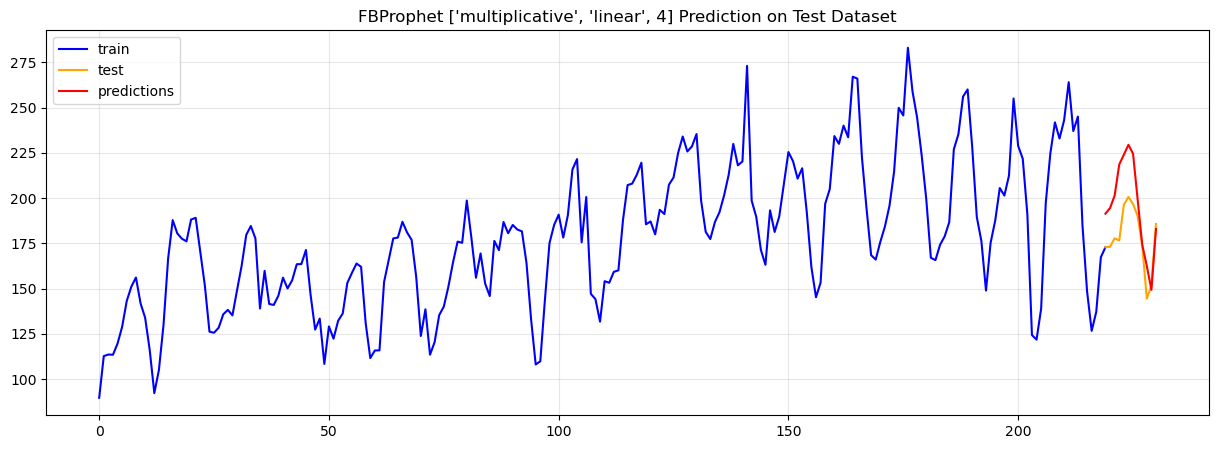

In [1255]:
prophet_results_df = test_Prophet_model(DATA['Other Pen. States'][1], 'real production data', False, False)

### [Extra task] Usage of N-Beats Library

In [1256]:
import torch
from torch import optim
from torch.nn import functional as F

from nbeats_pytorch.model import NBeatsNet

In [1257]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

def plot_scatter_without_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)

# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

In [1258]:
def train_test_Nbeats(x_train, y_train, x_test, y_test, order, forecast_length,
                      backcast_length, norm_constant, show_plots):
    batch_size = 10  # greater than 4 for viz

    # model
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=order,
    )
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())

    grad_step = 0
    forecast = []
    final_forecast = []
    for epoch in range(300):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        final_forecast = p
        if show_plots and epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    return final_forecast

In [1259]:
def get_train_test(prod_values, backcast_length, forecast_length):
    x, y = [], []
    for epoch in range(backcast_length, len(prod_values) - forecast_length):
        x.append(prod_values[epoch - backcast_length:epoch])
        y.append(prod_values[epoch:epoch + forecast_length])

    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]
    norm_constant = np.max(x_train)


    # normalization.
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant
    return x_train, y_train, x_test, y_test, norm_constant

In [1260]:
def optimize_Nbeats_model(order_list, train_validate_values, all_values, show_plots, debug_mode):
    best_model = dict()
    min_weighted_score = 1000_000
    forecast_length = 12
    backcast_length = 3 * forecast_length

    # data backcast/forecast generation.
    x_train, y_train, x_test, y_test, norm_constant = get_train_test(train_validate_values, backcast_length, forecast_length)

    # find the best orders for the model based on validation set
    best_model['order'] = order_list[0]
    for order in order_list:
        y_pred = train_test_Nbeats(x_train, y_train, x_test, y_test, order, forecast_length,
                                   backcast_length, norm_constant, show_plots)
        y_pred, xx, yy = y_pred[-1] * norm_constant, x_test[-1] * norm_constant, y_test[-1] * norm_constant
        model_forecast_accuracy = forecast_accuracy(y_pred, yy)

        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Order -- ', order)
            pprint(model_forecast_accuracy)

        # weighted_score
        weighted_score = 0.5 * (model_forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (model_forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['order'] = order
            best_model['prediction'] = y_pred
            best_model['model_accuracy'] = model_forecast_accuracy

    if show_plots:
        plt.figure(1)
        plot_scatter(range(0, backcast_length), xx, color='b')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), best_model['prediction'], color='r')
        plt.show()

    # test our model
    x_train2, y_train2, x_test2, y_test2, norm_constant2 = get_train_test(all_values, backcast_length, forecast_length)
    y_test_pred = train_test_Nbeats(x_train2, y_train2, x_test2, y_test2, best_model['order'], forecast_length,
                               backcast_length, norm_constant2, show_plots)
    y_test_pred, xx, yy = y_test_pred[-1] * norm_constant, x_test2[-1] * norm_constant, y_test2[-1] * norm_constant
    best_model_test_accuracy = forecast_accuracy(y_test_pred, yy)

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    pprint(best_model_test_accuracy)



    plt.figure(1)
    end_train_set = len(OtherPEN_production.Production) - forecast_length - SHIFT
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), y_test_pred, color='r')
    plt.show()

    plot_scatter_without_scatter(range(0, end_train_set),
                                 OtherPEN_production.Production[:-forecast_length - SHIFT], color='b')
    plot_scatter_without_scatter(range(end_train_set, end_train_set + forecast_length), yy, color='g')
    plot_scatter_without_scatter(range(end_train_set, end_train_set + forecast_length), y_test_pred, color='r')
    plt.show()

    return y_test_pred, best_model['order'], best_model_test_accuracy

In [1261]:
def test_Nbeats_model(time_series, series_name, show_plots, debug_mode):
    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Orders',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    # order_list = [32, 64, 128]
    order_list = [128]

    # for Prophet and Nbeats libraries I should not make  cross validation as for Prophet I used cross_validation function of this library
    # and for Nbeats we also have cross validation
    best_model_prediction_initial_series, best_model_order, best_model_test_accuracy =\
        optimize_Nbeats_model(order_list, time_series[:-PERIOD], time_series, show_plots, debug_mode)

    results_df.loc[i] = [3, series_name,
                         'Nbeats', best_model_order,
                         best_model_test_accuracy['1. Mean Absolute Percentage Error (MAPE)'],
                         best_model_test_accuracy['2. Mean Percentage Error (MPE)'],
                         best_model_test_accuracy['3. Root Mean Squared Error (RMSE)']]

    return results_df

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507342160
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507343056
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=36, forecast_length=12, share_thetas=False) at @139754500548752
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507270160
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507270544
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507272848


 ==================== Forecast Accuracy ====================
Order --  128
{'1. Mean Absolute Percentage Err

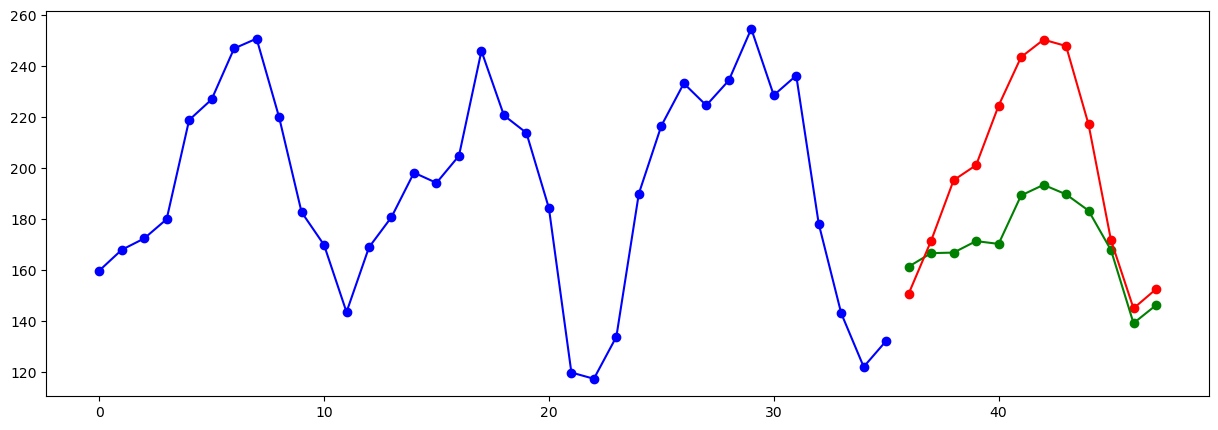

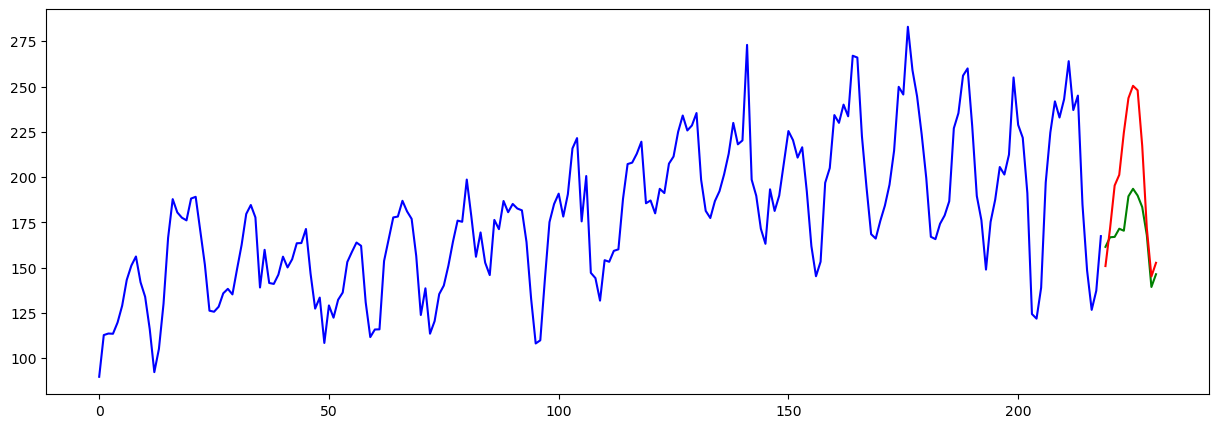

,Iteration,Stationary_Series_Name,Model_Name,Model_Orders,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
20,3,original production data,Nbeats,128,0.161269,0.150313,35.998372


In [1262]:
Nbeats_results_df = test_Nbeats_model(OtherPEN_production.Production[SHIFT: -SHIFT].values, 'original production data', False, True)
Nbeats_results_df

### Best Forcasts of AR, MA, ARMA and ARIMA models (based on Cross-Validation)

In [1263]:
total_results_df = pd.concat([
    additive_ML_DL_results_df,
    multiplicative_ML_DL_results_df,
    prophet_results_df,
    Nbeats_results_df
])
total_results_df

,Iteration,Stationary_Series_Name,Model_Name,Model_Orders,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,additive_decomposed_production,Conv1d model,"[30, 64, 400]",0.114711,0.070459,22.908938
1,2,additive_decomposed_production,LSTM,"[20, 12, 400]",0.050527,-0.017167,13.735057
2,3,additive_decomposed_production,Random Forest,"[1000, 100]",0.138323,0.119438,31.766511
0,1,multiplicative_decomposed_production,Random Forest,"[100, 100]",0.104594,0.061418,20.768534
1,2,multiplicative_decomposed_production,LSTM,"[20, 12, 400]",0.056375,-0.002823,14.397626
2,3,multiplicative_decomposed_production,XGBoost,"[100, 4, 1]",0.133673,0.121817,29.934821
20,3,real production data,FBProphet,"[multiplicative, linear, 4]",0.102696,0.097650,22.196593
20,3,original production data,Nbeats,128,0.161269,0.150313,35.998372


### Conclusion

From the above dataframe we see that prediction **on multiplicative decomposed values** is the best. For this multiplicative time series LSTM showed the best result as it has the smallest error from different measurements. LSTM showed **the best result for the second iteration of cross validation** and during my testing and debugging also was **pretty close to SimpleRNN on the third iteration**. On my notebook execution LSTM got such results.

That's why for forecasting out of our time series I chosen LSTM.

| Stationary_Series_Name | Model_Name | Model_Orders | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| multiplicative_decomposed_production | LSTM | [20, 12, 400] | 0.045044 | -0.011372 | 12.012046 |

<a id='section_7'></a>
## Section 7. Predict on 12 months out of dataframe

In [58]:
def get_extrapolated_trend(trend):
    X = trend.index[:, np.newaxis]
    y = trend.values[:, np.newaxis]

    poly_reg = PolynomialFeatures(degree=2)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)

    predict_idx = np.array([trend.index[-1] + i for i in range(1, 13)])
    X_actual_and_forecast = np.concatenate((X, predict_idx[:, np.newaxis]))
    polynomial_trend_prediction = pol_reg.predict(poly_reg.fit_transform(X_actual_and_forecast))

    # Visualizing the Polymonial Regression results
    plt.scatter(X, y, color='red')
    plt.plot(X_actual_and_forecast, polynomial_trend_prediction, color='blue')
    plt.ylabel('Production')
    plt.title('Extrapolation of trend')
    plt.show()

    return polynomial_trend_prediction.flatten()

In [59]:
def extrapolate_seasonality(seasonality, num_periods):
    new_seasonality = pd.concat([seasonality, seasonality[:num_periods * PERIOD]])
    new_seasonality.index = range(0, len(new_seasonality))
    plt.plot(new_seasonality)
    plt.title('Extrapolation of seasonality')
    plt.show()
    return new_seasonality

In [62]:
def get_train_validate_test_splits_for_final_test(values):
    train_length = 201 - max(RAINFALL_LAGS)
    validate_length = PERIOD # also equal to test length

    test = values[train_length + validate_length: train_length + 2 * validate_length, :]

    test_X, test_y = test[:, :-1], test[:, -1]
    full_df_X, full_df_y = values[:, :-1], values[:, -1]

    return [(test_X, test_y), (full_df_X, full_df_y)]


def predict_out_of_df(stationary_series, best_model_order, model_name):
    full_df, SCALER = create_feature_df_for_stationary(stationary_series)
    test, full_df_split = get_train_validate_test_splits_for_final_test(full_df)
    test_X, test_y = test
    full_df_X, full_df_y = full_df_split

    # reshape input to be 3D [samples, timesteps, features]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    full_df_X = full_df_X.reshape((full_df_X.shape[0], 1, full_df_X.shape[1]))

    test_model = fit_LSTM_features(full_df_X, full_df_y, None, None, best_model_order, True)

    yhat = test_model_with_transform(test_model, test_X, model_name, -1)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, yhat), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    predicted_trend = extrapolate_seasonality(multiplicative_decomposed_seasonal, 1)[-PERIOD:]
    predicted_seasonality = get_extrapolated_trend(multiplicative_decomposed_trend)[-PERIOD:]

    model_prediction_initial_series = inv_yhat * predicted_trend * predicted_seasonality

    start_idx = len(OtherPEN_production.Production[:-SHIFT])
    end_idx = start_idx + PERIOD
    x_indices = range(start_idx, end_idx)
    print("model_prediction_initial_series -- ", model_prediction_initial_series.values)

    # add + 1 to make consistent plot
    plt.plot(OtherPEN_production.Production[:-SHIFT], color='blue', label="initial time series")
    plt.plot(x_indices, model_prediction_initial_series, color='red', label="predictions")
    plt.legend(loc='upper left')
    plt.title(f'{model_name} {best_model_order} Prediction on Test Dataset')
    plt.grid(alpha=0.3)
    plt.show()

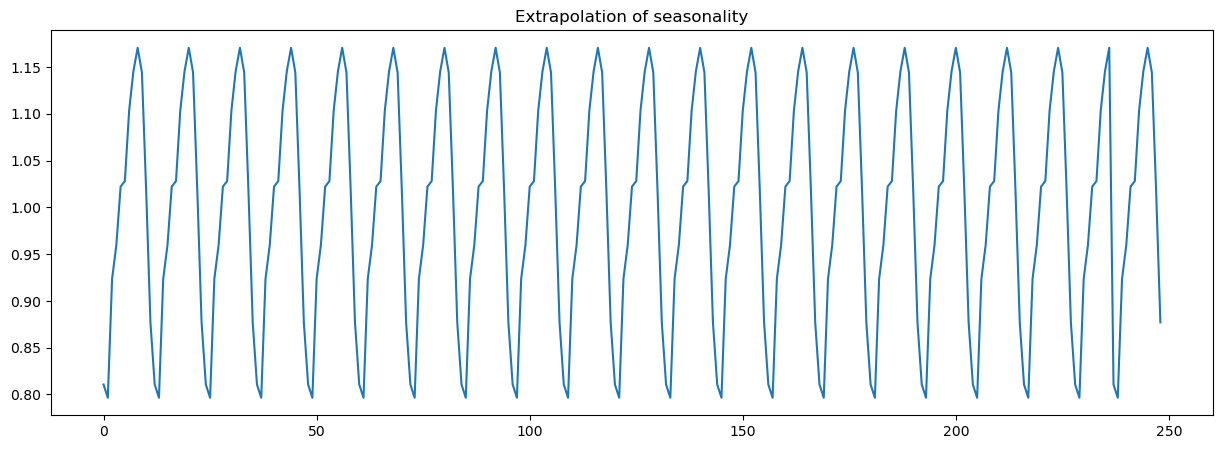

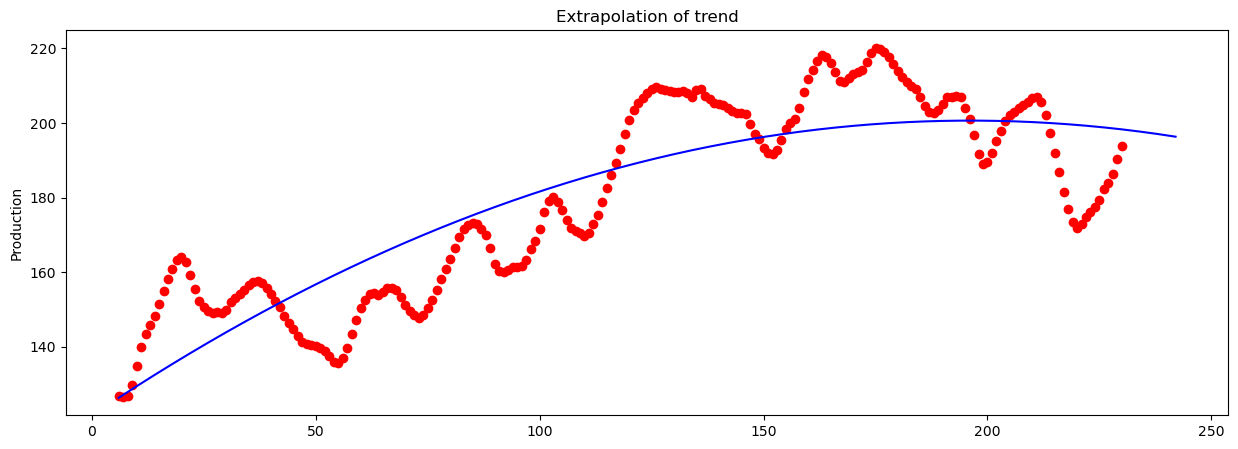

model_prediction_initial_series --  [163.55833909 153.91934745 173.98519977 186.14253405 204.555527
 206.65170645 219.53063643 228.28314515 226.29864213 220.41687323
 189.08903556 168.33094131]


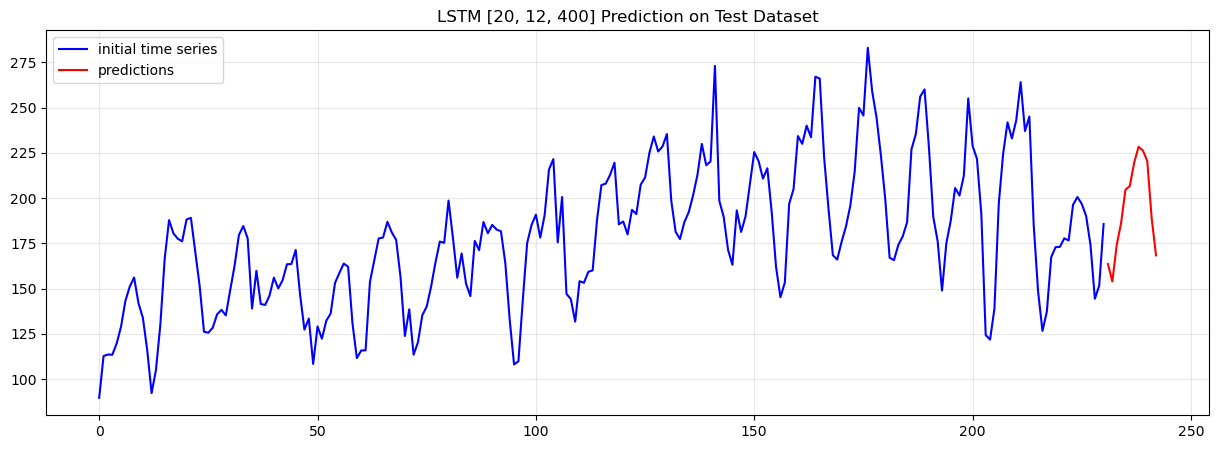

In [63]:
predict_out_of_df(multiplicative_decomposed_production, [20, 12, 400], 'LSTM')